# 2022-02-22 Ultra-fast categorization of image containing animals *in sillico*

Hi! I am  [Jean-Nicolas Jérémie](https://github.com/JNJER) in this notebook, I will use the [Pytorch](https://pytorch.org/) library to run the networks and the [pandas](https://pandas.pydata.org/docs/getting_started/index.html) library to collect and display the results. This notebook focused on the training and the test of Deep convolutional neuronal networks (DCNNs) for ecological tasks such as detecting an animal in a natural scene.

I uses transfer learning to train the DCNN, starting from a VGG16 network, taken from the `torchvision.models` library, pre-trained on the [Imagenet](http://image-net.org/) dataset which allows to perform label detection on naturals images for $K = 1000$ labels. Then re-train the whole network to perfom the same task but in a sub-set of $K = 1$ synset from the Imagenet dataset. The dataset I used here to train the networks is not multilabel (as we have the information about the occurence of only one synset on the scene), in order to train networks on independant task I choose to limit the output of the DCNN to $K = 1$ synset. 
Here, I am going to adopt differents strategies of transfer learning:

* VGG General : Substitute the last layer of the Pytorch VGG16 network ($K = 1000$ labels) with a new layer build from a specific subset ($K = 10$ labels).
* VGG Gray : Same architecture as the VGG General network but trained with images in grayscale.
* VGG Scale : Same architecture as the VGG General network but trained with images of different size.

The first part consist of the training of the network and the last part of this notebook is dedicated to the test of the robustness of the resulted networks while appliying various geometric tranformations to the input. Finally I analyse the similarities in the performances of the networks compared with physiological data. 

This notebook was done during my thesis at the Neurosciences Institute of Timone (INT) under the supervision of [Laurent PERRINET](https://laurentperrinet.github.io/). It is curated in the following [github repo](https://github.com/JNJER/2022-03_UltraFastCat).

*Some useful links :* TODO

Let's first install requirements

In [1]:
%pip install --upgrade -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
%mkdir -p UltraFastCat

# Trainning process

This part of the notebook focus on the training process of the network. I use the variables set in the scripts generated by the `Ìnit_src.ipynb` noteboook.
The script `experiment_train.py`, a pretty classic trainning script with pytorch. Since I only have one synset to discriminate in the scene i use `criterion = nn.BCEWithLogitsLoss()` to compute the loss during the training process. For further statistical analyses, we extract factors (like the accuracy and loss) in a `pandas` object. 

In [3]:
scriptname = 'UltraFastCat/experiment_train.py'

In [4]:
%%writefile {scriptname}
from src.model import *  
from PIL import ImageFile
import math
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train_model(model, num_epochs, dataloaders, lr=args.lr, momentum=args.momentum, beta2=args.beta2, log_interval=100, **kwargs):
    
    model.to(device)
    if beta2 > 0.: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(momentum, beta2)) #, amsgrad=amsgrad)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum) # to set training variables

    df_train = pd.DataFrame([], columns=['epoch', 'avg_loss', 'avg_acc', 'avg_loss_val', 'avg_acc_val', 'device_type']) 

    for epoch in range(num_epochs):
        loss_train = 0
        acc_train = 0
        for i, (images, labels) in enumerate(dataloaders['train']):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs[:,0], labels.float())

            loss.backward()
            optimizer.step()

            loss_train += loss.item() * images.size(0)
            preds = torch.round(torch.sigmoid(outputs[:,0].data))
            acc_train += torch.sum(preds == labels.data)
            
        avg_loss = loss_train / dataset_sizes[task]['train']
        avg_acc = acc_train / dataset_sizes[task]['train']
           
        with torch.no_grad():
            loss_val = 0
            acc_val = 0
            for i, (images, labels) in enumerate(dataloaders['val']):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs[:,0], labels.float())

                loss_val += loss.item() * images.size(0)
                preds = torch.round(torch.sigmoid(outputs[:,0].data))
                acc_val += torch.sum(preds == labels.data)
        
            avg_loss_val = loss_val / dataset_sizes[task]['val']
            avg_acc_val = acc_val / dataset_sizes[task]['val']
        
        df_train.loc[epoch] = {'epoch':epoch, 'avg_loss':avg_loss, 'avg_acc':float(avg_acc),
                               'avg_loss_val':avg_loss_val, 'avg_acc_val':float(avg_acc_val), 'device_type':device.type}
        print(f"Epoch {epoch+1}/{num_epochs} : train= loss: {avg_loss:.4f} / acc : {avg_acc:.4f} - val= loss : {avg_loss_val:.4f} / acc : {avg_acc_val:.4f}")

    model.cpu()
    torch.cuda.empty_cache()
    return model, df_train

# https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451
criterion = nn.BCEWithLogitsLoss() #binary_cross_entropy_with_logits

# Training and saving the network

models_vgg = {}
opt = {}
n_output = 1
all_models = []
    
# Downloading the model
model_filenames = {}
for task in args.tasks :
    for model in args.model_names:
        model_name = model+'_'+task
        all_models.append(model_name)
        model_filenames[model_name] = args.model_path + model_name + '.pt'
        filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'

        models_vgg[model_name] = torchvision.models.vgg16(pretrained=True) 

        num_features = models_vgg[model_name].classifier[-1].in_features
        features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, n_output)]) # Add our layer with 10 outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier

        if os.path.isfile(model_filenames[model_name]):
            print("Loading pretrained model for..", model_name, ' from', model_filenames[model_name])

            if device.type == 'cuda':
                models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name])) #on GPU
            else:
                models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name], map_location=torch.device('cpu'))) #on CPU

        else:
            print("Re-training pretrained model...", model_filenames[model_name])
            since = time.time()
            p = 1 if 'gray' in model_name  else 0
            if 'scale' in model_name:
                df_train = None
                for image_size_ in args.image_sizes: # starting with low resolution images 
                    print(f"Traning {model_name}, image_size = {image_size_}, p (Grayscale) = {p}")
                    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size_, p=p)
                    models_vgg[model_name], df_train_ = train_model(models_vgg[model_name], num_epochs=args.num_epochs//len(args.image_sizes),
                                                                 dataloaders=dataloaders[task])
                    df_train = df_train_ if df_train is None else df_train.append(df_train_, ignore_index=True)
            else :
                print(f"Traning {model_name}, image_size = {args.image_size}, p (Grayscale) = {p}")
                (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, p=p)
                models_vgg[model_name], df_train = train_model(models_vgg[model_name], num_epochs=args.num_epochs,
                                                            dataloaders=dataloaders[task])
            torch.save(models_vgg[model_name].state_dict(), model_filenames[model_name])
            df_train.to_json(filename)
            elapsed_time = time.time() - since
            print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
            print()
            
updict = {"vgg_16" : torchvision.models.vgg16(pretrained=True)}
updict.update(models_vgg)
models_vgg = updict

Overwriting UltraFastCat/experiment_train.py


In [5]:
%run -int {scriptname}

Creating file results/2022-05-15_config_args.json
On date 2022-05-15 , Running benchmark on host babbage  with device cuda
-----------------------------
List of Pre-selected tasks : 
-----------------------------
398  Targets for the task : animal
602  Distractors for the task : animal
------
animal
------
Loaded 1200 images under test
Loaded 800 images under val
Loaded 2000 images under train


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/laurent/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Re-training pretrained model... models/re-trained_vgg16_gen_animal.pt
Traning vgg16_gen_animal, image_size = 256, p (Grayscale) = 0


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 5.93 GiB total capacity; 537.06 MiB already allocated; 474.00 MiB free; 542.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


IPython CPU timings (estimated):
  User   :      10.03 s.
  System :       2.36 s.
Wall time:      15.52 s.


## Average accuracy and loss

Here we display both average accuracy and loss during the training phase and during the validation one : 

In [6]:
datetag = '2021-11-18'
for model_name in all_models:
    filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi/2))
    ax = df_train['avg_loss'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_loss_val'].plot(lw=2, marker='.', markersize=10)
    ax.legend(["avg_loss", "avg_loss_val"], fontsize=18);
    ax.set_xlabel("Epoch", size=18)
    ax.spines['left'].set_position(('axes', -0.01))
    ax.set_xlim(-0.5, args.num_epochs)
    ax.grid(which='both')
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
    ax.set_ylim(0., 1.1)
    axs.set_title(f'Average values of the loss by epoch : {filename}' , size = 20)
    ax.get_legend().remove()
    fig.legend(bbox_to_anchor=(1.05, .5), loc='lower right', fontsize = 20)

ValueError: Expected object or value

In [7]:
for model_name in all_models:
    filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi/2))
    ax = df_train['avg_acc'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_acc_val'].plot(lw=2, marker='.', markersize=10)
    ax.legend(["avg_acc", "avg_acc_val"], fontsize=18);
    ax.set_xlabel("Epoch", size=18)
    ax.spines['left'].set_position(('axes', -0.01))
    ax.set_ylim(0.70, .992)
    ax.set_yscale("logit", one_half="1/2", use_overline=True)
    ax.grid(which='both')
    ax.set_xlim(-0.5, args.num_epochs+.5)
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
    axs.set_title(f'Average values of the accuracy by epoch : {filename}' , size = 20)
    ax.get_legend().remove()
    fig.legend(bbox_to_anchor=(1.05, .5), loc='lower right', fontsize=20)

ValueError: Expected object or value

# Testing the new networks

Now that the networks seems ready for the comparison. The second part of this notebook offers a comparison between:

- A pre-trained image recognition's networks, here VGG, trained on the [Imagenet](http://image-net.org/) dataset wich allows to work on naturals images for $1000$ labels, taken from the `torchvision.models` library

- And three re-trained version of the same network VGG16 based on a Wordnet semantic from the Imagenet database wich allows to work on naturals images for $1$ synsets. 

As a control I re-train networks on the artifact synset too. Another interresing analysis will be the study of the link between the performances on these two conditions. 

<a id="exp1"></a>
## Experiment 1: Image processing and recognition for differents labels 

In [8]:
scriptname =  'UltraFastCat/experiment_basic.py'

In [9]:
%%writefile {scriptname}

#import model's script and set the output file
from experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
filename = f'results/{datetag}_results_1_{args.HOST}.json'
print(f'{filename=}')

def main():
    if os.path.isfile(filename):
        df = pd.read_json(filename)
    else:
        i_trial = 0
        df = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
            # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        for task in args.tasks:
            pprint(task)
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data, label = data.to(device), label.to(device)
                for model_name in models_vgg:
                    model = models_vgg[model_name].to(device)
                    with torch.no_grad():
                        goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                        model_task = 'animal' if 'animal' in model_name else 'artifact'
                        tic = time.time()
                        out = model(data).squeeze(0)
                        if model_name == 'vgg_16':
                            temp_, likelihood = 0, 0
                            model_task = 'Imagenet_challenge'
                            percentage = torch.nn.functional.softmax(out, dim=0) * 100
                            for idx in np.arange(0, 1000, 1): #Todo : check calcul likelihood
                                if idx in match[task]:
                                    likelihood += math.exp(percentage[idx].item())
                                else:
                                    temp_ += math.exp(percentage[idx].item())  
                            likelihood = likelihood/temp_
                        else:
                            likelihood = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                        top_1 = 'target' if likelihood>50 else 'distractor'
                        elapsed_time = time.time() - tic
                    df.loc[i_trial] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                          'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                    print(f'The {model_name} model categorize {model_task} with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                    i_trial += 1
        df.to_json(filename)
main()         

Overwriting UltraFastCat/experiment_basic.py


In [10]:
%run -int {scriptname}

Re-training pretrained model... models/re-trained_vgg16_gen_animal.pt
Traning vgg16_gen_animal, image_size = 256, p (Grayscale) = 0


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 5.93 GiB total capacity; 986.08 MiB already allocated; 20.00 MiB free; 996.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


IPython CPU timings (estimated):
  User   :       1.61 s.
  System :       0.40 s.
Wall time:       1.75 s.


In [11]:
model_animal = []
model_artifact = []
filename = f'results/{datetag}_results_1_{args.HOST}.json'
df = pd.read_json(filename)
data_animal = df.loc[df['model_task'] == 'animal']
data_artifact = df.loc[df['model_task'] == 'artifact']
for model in models_vgg:
    model_animal.append(model) if 'animal' in model else model_artifact.append(model)

ValueError: Expected object or value

### Animal

On this notebook I choose to focus on the analysis of the networks trained on a specific task on both animal and artifact datasets.

#### Image display

I displayed the images in various conditions with the likelihood at the output of the network as the `y_label`, the label found by the network and the name of the networks as the `x_label`. If the labels are in green the categorization made by the network is correct (detect a target:'animal' in the scene when there is indeed an animal in the scene), if the labels are red the network failed the categorization. 

Here is the images with the higher likelihood of the networks : 

NameError: name 'data_animal' is not defined

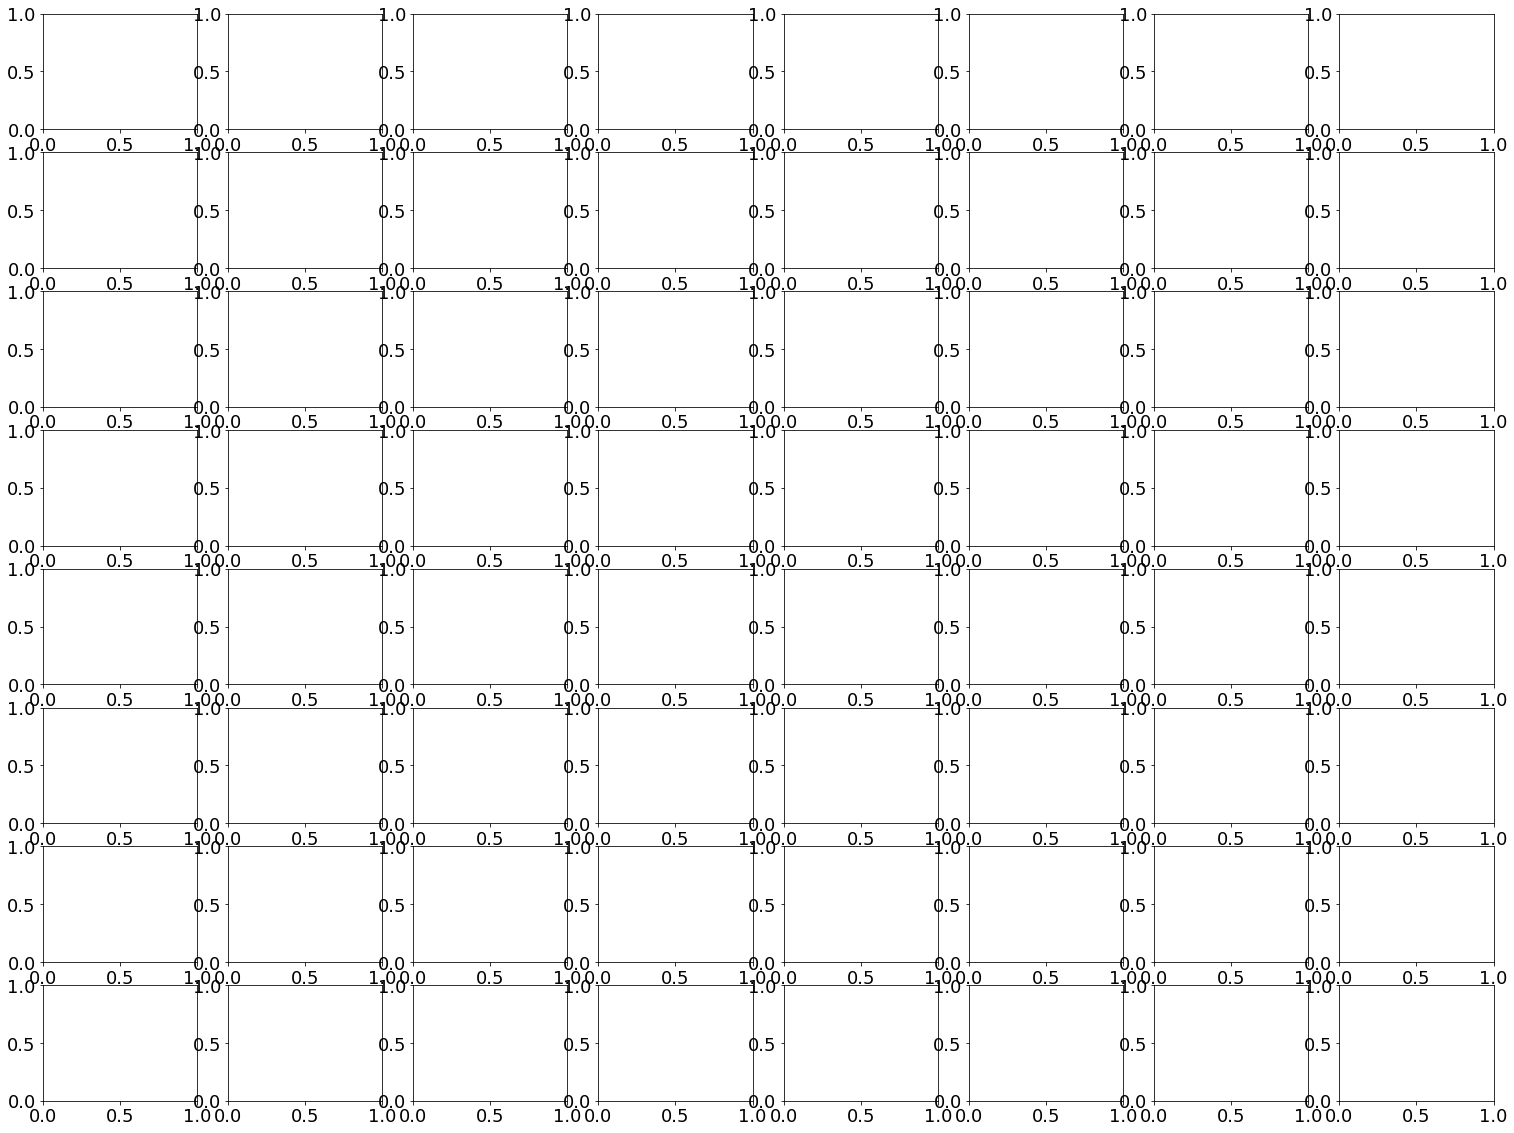

In [12]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_animal.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_animal.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_animal.loc[idx]['top_1'] == data_animal.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_animal.loc[idx]['top_1'] + ' | ' + data_animal.loc[idx]['model'], color=color)
    likelihood = data_animal.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'data_animal' is not defined

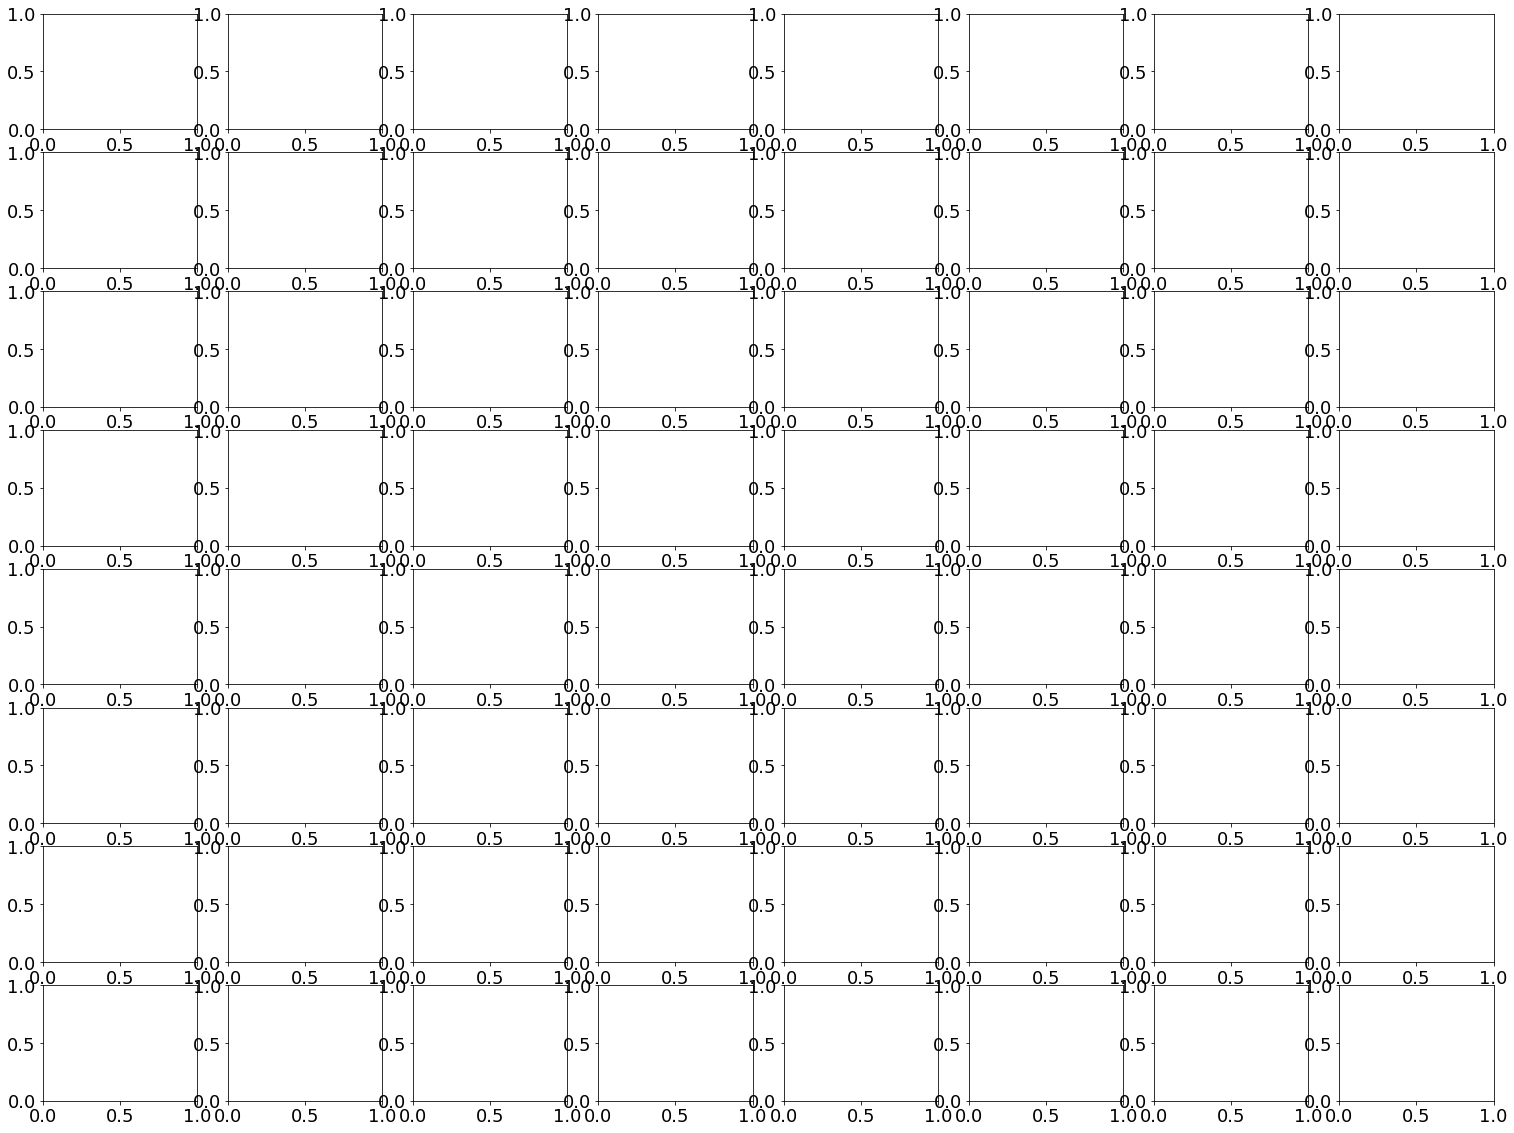

In [13]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_animal.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_animal.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_animal.loc[idx]['top_1'] == data_animal.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_animal.loc[idx]['top_1'] + ' | ' + data_animal.loc[idx]['model'], color=color)
    likelihood = data_animal.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)  
fig.set_facecolor(color='white')

#### Accuracy

In [14]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
df_acc = pd.DataFrame({model_name: {task: f1_score(data_animal[(data_animal['model']==model_name) & (data_animal['task']==task)]["top_1"], 
                                                               data_animal[(data_animal['model']==model_name) & (data_animal['task']==task)]["goal"],
                                                  average = 'micro')
                                    for task in args.tasks} 
                       for model_name in model_animal})
test = df_acc
ax = df_acc.T.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=20)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(all_models)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=60)
plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=18)
ax.set_title(f'Animal vs Artifact images f1 score for re-trained models', size=22)
ax.set_ylabel('Accuracy', size=20)
ax.set_xlabel('Model', size=20);

TypeError: no numeric data to plot

### Artifact

#### Image display

Here is the images with the highest likelihood of the networks :

NameError: name 'data_artifact' is not defined

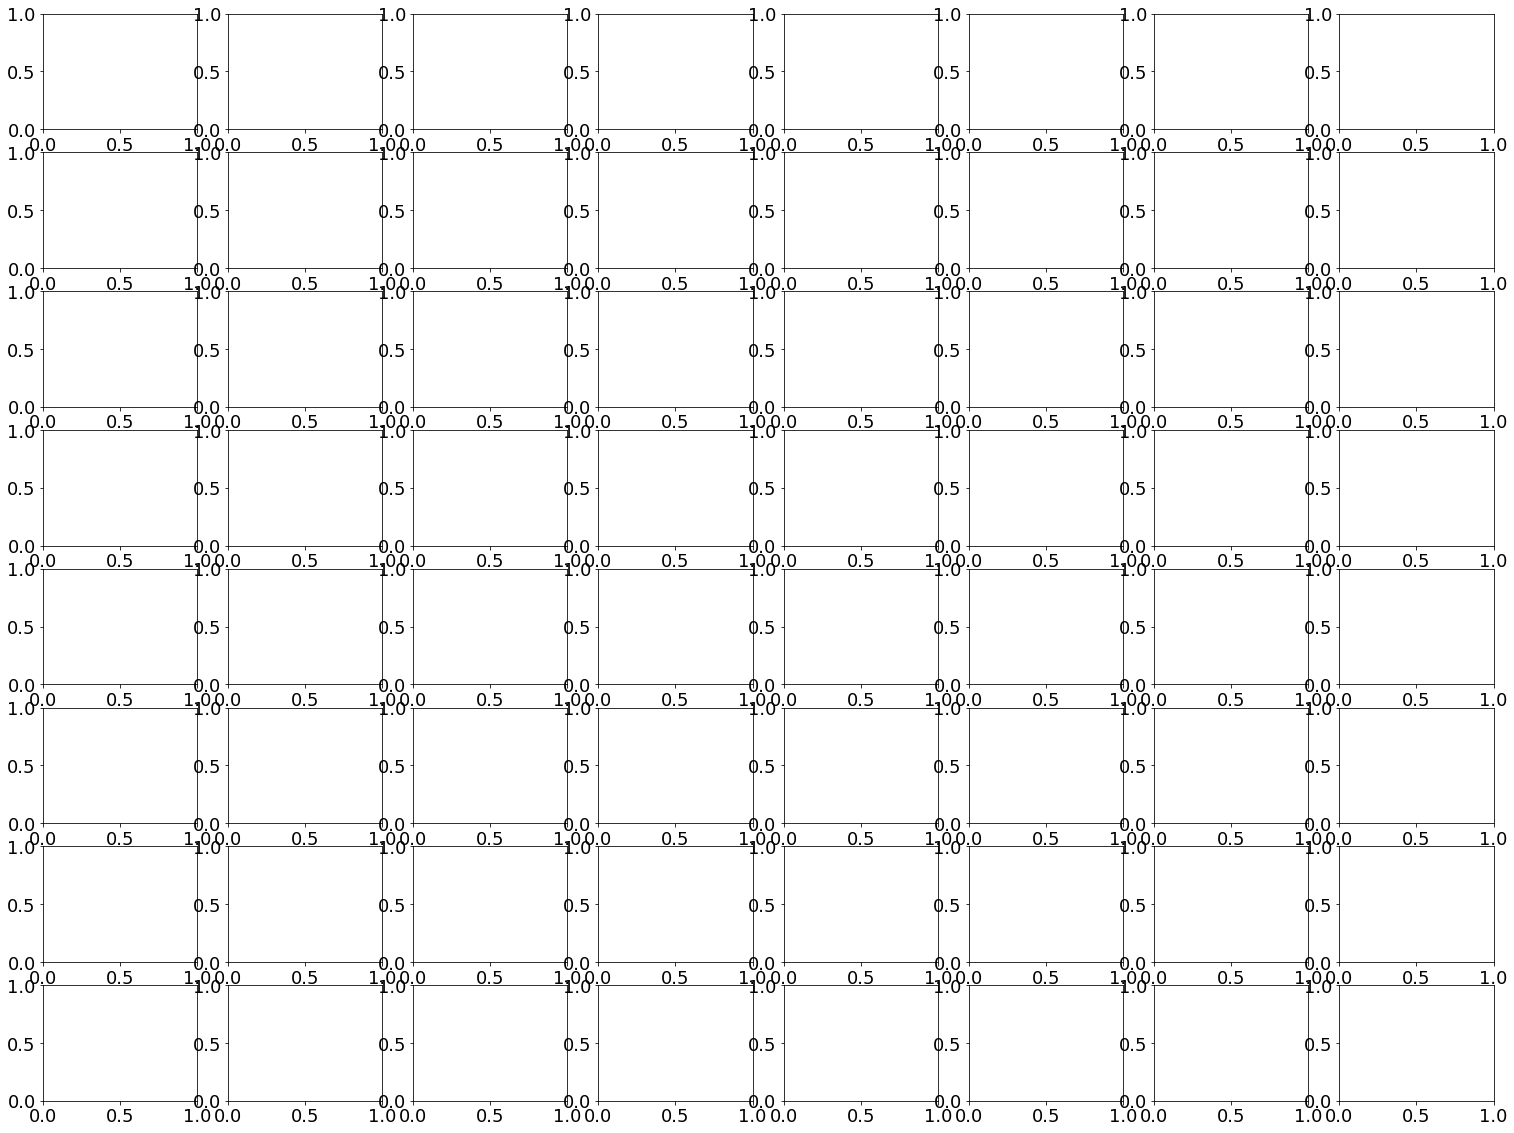

In [15]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_artifact.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['artifact']['test'].imgs[data_artifact.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_artifact.loc[idx]['top_1'] == data_artifact.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_artifact.loc[idx]['top_1'] + ' | ' + data_artifact.loc[idx]['model'], color=color)
    likelihood = data_artifact.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'data_artifact' is not defined

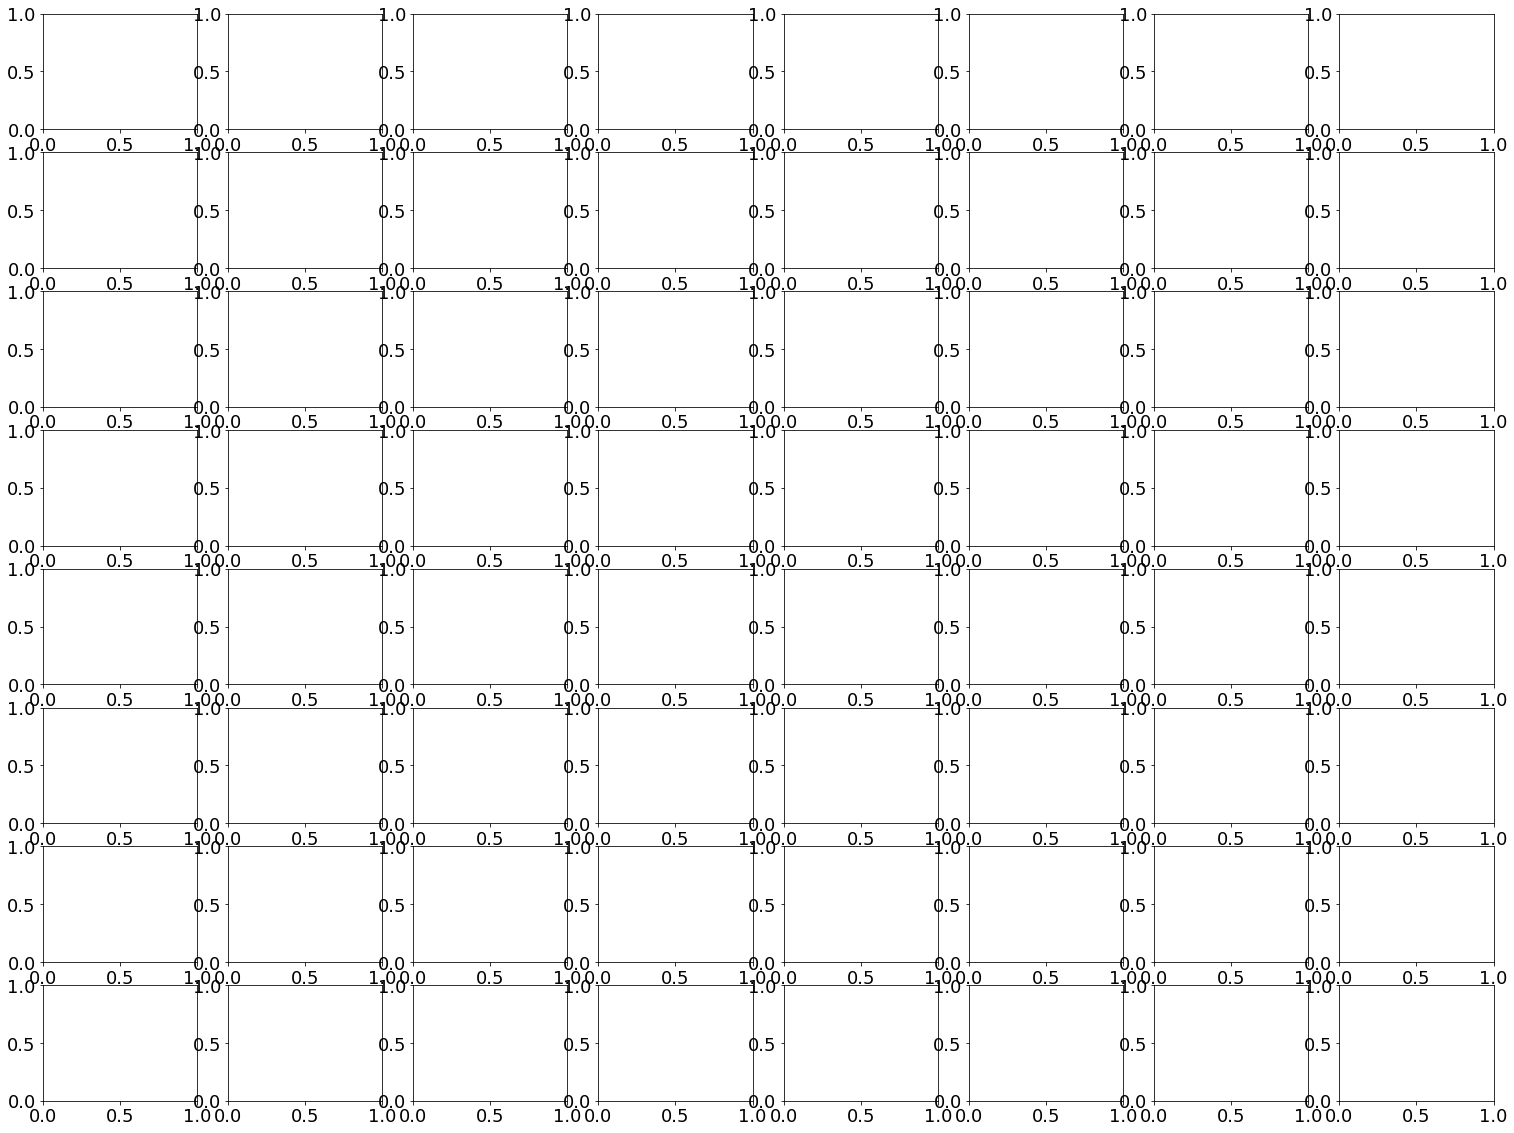

In [16]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_artifact.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['artifact']['test'].imgs[data_artifact.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_artifact.loc[idx]['top_1'] == data_artifact.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_artifact.loc[idx]['top_1'] + ' | ' + data_artifact.loc[idx]['model'], color=color)
    likelihood = data_artifact.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color) 
fig.set_facecolor(color='white')

#### Accuracy

In [17]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
model_artifact.pop(0)
df_acc = pd.DataFrame({model_name: {task: f1_score(data_artifact[(data_artifact['model']==model_name) & (data_artifact['task']==task)]["top_1"], 
                                                               data_artifact[(data_artifact['model']==model_name) & (data_artifact['task']==task)]["goal"],
                                                  average = 'micro')
                                    for task in args.tasks} 
                       for model_name in model_artifact})

ax = df_acc.T.plot.bar(rot=20, figsize=(fig_width, fig_width//4), fontsize=20)
test_ = df_acc
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=60)
plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=18)
ax.set_title(f'Animal vs Artifact images f1 score for re-trained models', size=22)
ax.set_ylabel('Accuracy', size=20)
ax.set_xlabel('Model', size=20);

IndexError: pop from empty list

### Summary

#### Computation Time

NameError: name 'df' is not defined

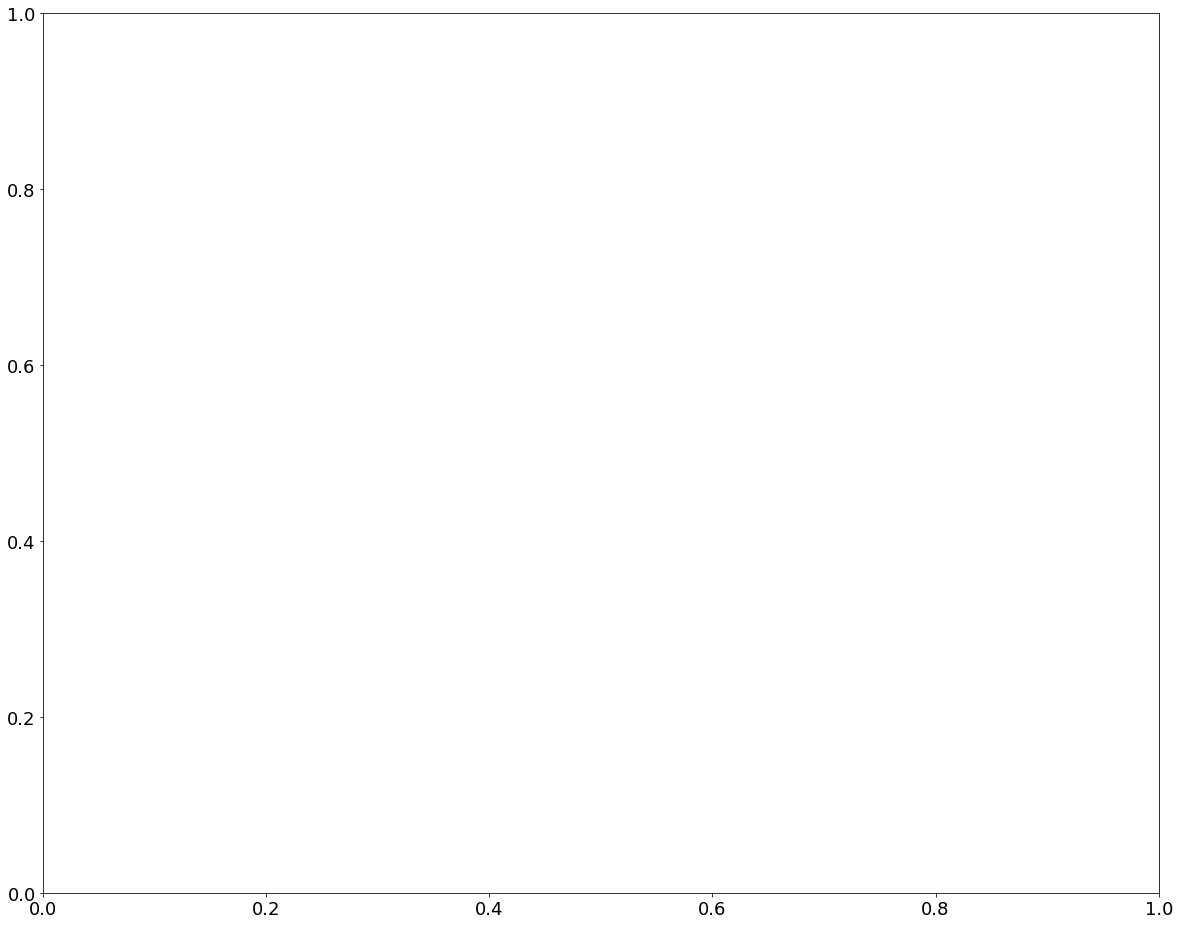

In [18]:
fig, axs = plt.subplots(len(models_vgg), 1, figsize=(fig_width, fig_width*phi/2), sharex=True, sharey=True)
cmap = plt.cm.get_cmap('inferno')
color_dict = pd.Series({k:cmap(i/len(df['model'].unique())) for i,k in enumerate(df['model'].unique())})
for ax, color, model_name in zip(axs, color_dict, models_vgg):
    df[df['model']==model_name]['time'].plot.hist(bins=50, lw=1, label=model_name,ax=ax, color=[color_dict[model_name],], density=True)
    ax.set_xlim(df['time'].quantile(.01), df['time'].quantile(.99))
    ax.set_ylim(0, 3500)
    ax.legend(bbox_to_anchor=(1.21, .35), loc='lower right', fontsize=15)
    ax.grid(which='both', axis='y')
    ax.set_xlabel('Processing time (s): ' + model_name, size=22)
    ax.set_ylabel('')
axs[0].set_title('Distribution of the Processing time (s). Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20)
axs[len(models_vgg)//2].set_ylabel('Frequency', fontsize=22);

#### Accuracy comparison for all the models

NameError: name 'df' is not defined

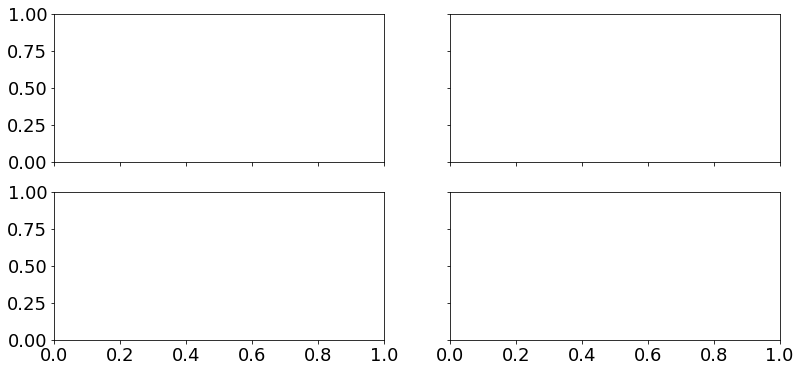

In [19]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
animal_acc = {}
artifact_acc = {}
df_test = []
x= ['Gen', 'Scale', 'Gray']
fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(fig_width//1.5, fig_width//3))
for task in args.tasks:
    temp_ = df.loc[df['task'] == task]
    animal_acc[task]=[]
    artifact_acc[task]=[]
    for model_name in models_vgg:
        if 'animal' in model_name:
            animal_acc[task].append(accuracy_score(temp_[temp_['model']==model_name]["top_1"], temp_[temp_['model']==model_name]["goal"]))
        elif 'artifact' in model_name:
            artifact_acc[task].append(accuracy_score(temp_[temp_['model']==model_name]["top_1"], temp_[temp_['model']==model_name]["goal"]))

    df_test.append(animal_acc[task])
    df_test.append(artifact_acc[task])

cmap = plt.cm.get_cmap('viridis_r')
color_dict = pd.Series({k:cmap(i/len(x)) for i,k in enumerate(x)})

n= 3

titles = ["(A) Animal on animal", "(B) Animal on artifact" ,"(C) Artifact on animal" ,"(D) Artifact on artifact"]

ax1 = axs[0][0]
ax2 = axs[0][1]
ax3 = axs[1][0]
ax4 = axs[1][1]
ax1.bar(x, df_test[0], color= color_dict)
ax2.bar(x, df_test[1], color= color_dict)
ax3.bar(x, df_test[2], color= color_dict)
ax4.bar(x, df_test[3], color= color_dict)
ax1.set_ylim(0, 1)
ax3.set_ylim(0, 1)
ax1.hlines(xmin=-.5, xmax=2.5, y=1/2, ls='--', ec='k')
ax2.hlines(xmin=-.5, xmax=2.5, y=1/2, ls='--', ec='k')
ax3.hlines(xmin=-.5, xmax=2.5, y=1/2, ls='--', ec='k')
ax4.hlines(xmin=-.5, xmax=2.5, y=1/2, ls='--', ec='k')
ax1.set_title(titles[0], fontsize = 18, fontweight="bold")
ax2.set_title(titles[1], fontsize = 18, fontweight="bold")
ax3.set_title(titles[2], fontsize = 18, fontweight="bold")
ax4.set_title(titles[3], fontsize = 18, fontweight="bold")
axxx = [ax1, ax2, ax3, ax4]
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for axs in axxx:
    for i, container in enumerate(axs.containers): axs.bar_label(container, padding=-50, color='black', fontsize=18, fmt='%.3f', rotation=0, label_type = 'edge', fontweight='bold')
#plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=15)
plt.xticks(fontsize=20,  fontweight='bold')

ax1.set_ylabel('Accuracy', fontsize=20, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=20, fontweight='bold')
plt.tight_layout();
ax3.set_xticks([])
plt.yticks(fontsize=20,  fontweight='bold');
#plt.savefig('IJCNN_fig.5.pdf');


#### Conclusion

We tested the networks Vgg Gen, Vgg Scale and Vgg Gray trained to detect an animal on the dataset where the targets are 'animal' (respectively train to detect an artifact on dataset where targets are artifacts). Then we tested the networks trained to detect an 'animal' on the dataset where the targets are 'artifact' and vice versa. Here, by exposing the predictions for the 'animal' and 'artifact' labels, we highlight a bias in the composition of the dataset. Although the outputs are independent, 'animal' images confidently correspond to 'non-artifact' images (and vice versa), thus facilitating the overall detection.

### Todo : Analysis network serre/person

<a id="exp2"></a>
## Experiment 2: Image processing and recognition for differents flip transformations

In [20]:
scriptname =  'UltraFastCat/experiment_flip.py'

In [21]:
%%writefile {scriptname}

#import model's script and set the output file
from experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

flips = {}
flips['Horizontal'] = transforms.RandomHorizontalFlip(p=1)
flips['Vertical'] = transforms.RandomVerticalFlip(p=1)

filename = f'results/{datetag}_results_flip_{args.HOST}.json'
print(f'{filename=}')

def main():
    if os.path.isfile(filename):
        df = pd.read_json(filename)
    else:
        i_trial = 0
        df_flip = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type', 'flip'])   
        # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        for flip in flips:
            pprint(flip)
            for task in args.tasks:
                for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                    data = flips[flip](data)
                    data, label, = data.to(device), label.to(device)
                    for model_name in models_vgg:
                        model = models_vgg[model_name].to(device)
                        with torch.no_grad():
                            goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                            model_task = 'animal' if 'animal' in model_name else 'artifact'
                            tic = time.time()
                            out = model(data).squeeze(0)
                            if model_name == 'vgg_16':
                                temp_, likelihood = 0, 0
                                model_task = 'Imagenet_challenge'
                                percentage = torch.nn.functional.softmax(out, dim=0) * 100
                                for idx in np.arange(0,1000,1):
                                    if idx in match[task]:
                                        likelihood += math.exp(percentage[idx].item())
                                    else:
                                        temp_ += math.exp(percentage[idx].item())  
                                likelihood = likelihood/temp_
                            else:
                                likelihood = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                            elapsed_time = time.time() - tic
                            top_1 = 'target' if likelihood>50 else 'distractor'
                        df_flip.loc[i_trial] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                               'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type, 'flip':flip}
                        print(f'The {model_name} model categorize {model_task} with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                        i_trial += 1

            df_flip.to_json(filename)
main()

Overwriting UltraFastCat/experiment_flip.py


In [22]:
%run -int {scriptname}

Re-training pretrained model... models/re-trained_vgg16_gen_animal.pt
Traning vgg16_gen_animal, image_size = 256, p (Grayscale) = 0


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 5.93 GiB total capacity; 962.08 MiB already allocated; 44.00 MiB free; 972.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


IPython CPU timings (estimated):
  User   :       1.69 s.
  System :       0.44 s.
Wall time:       1.80 s.


<Figure size 432x288 with 0 Axes>

In [23]:
datetag = '2021-12-07'
model_animal = []
model_artifact = []
filename = f'results/{datetag}_results_flip_{args.HOST}.json'
flips = {}
flips['Horizontal'] = transforms.RandomHorizontalFlip(p=1)
flips['Vertical'] = transforms.RandomVerticalFlip(p=1)
df_flip = pd.read_json(filename)
test = df_acc
data_animal = df_flip.loc[df_flip['model_task'] == 'animal']
data_artifact = df_flip.loc[df_flip['model_task'] == 'artifact']
for model in all_models:
    model_animal.append(model) if 'animal' in model else model_artifact.append(model)

ValueError: Expected object or value

### Animal

#### Image display

Here is the images with the highest likelihood of the networks :

NameError: name 'data_animal' is not defined

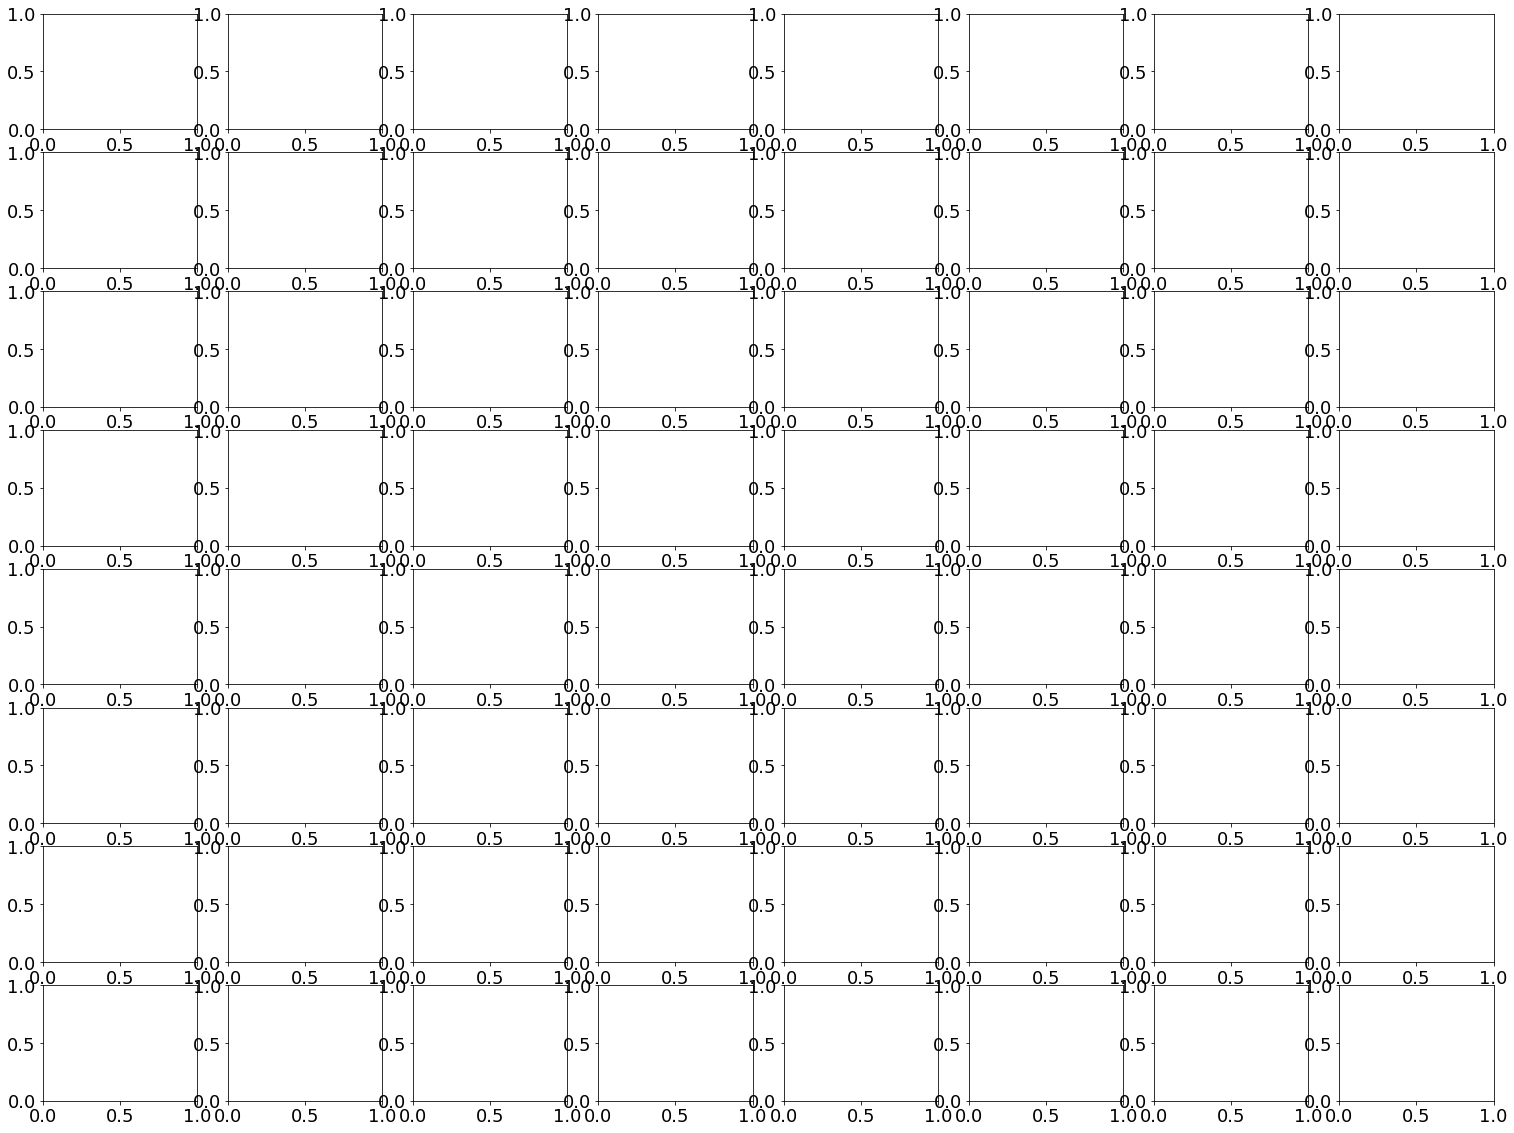

In [24]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_animal.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_animal.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_animal.loc[idx]['top_1'] == data_animal.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_animal.loc[idx]['top_1'] + ' | ' + data_animal.loc[idx]['model'], color=color)
    likelihood = data_animal.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'data_animal' is not defined

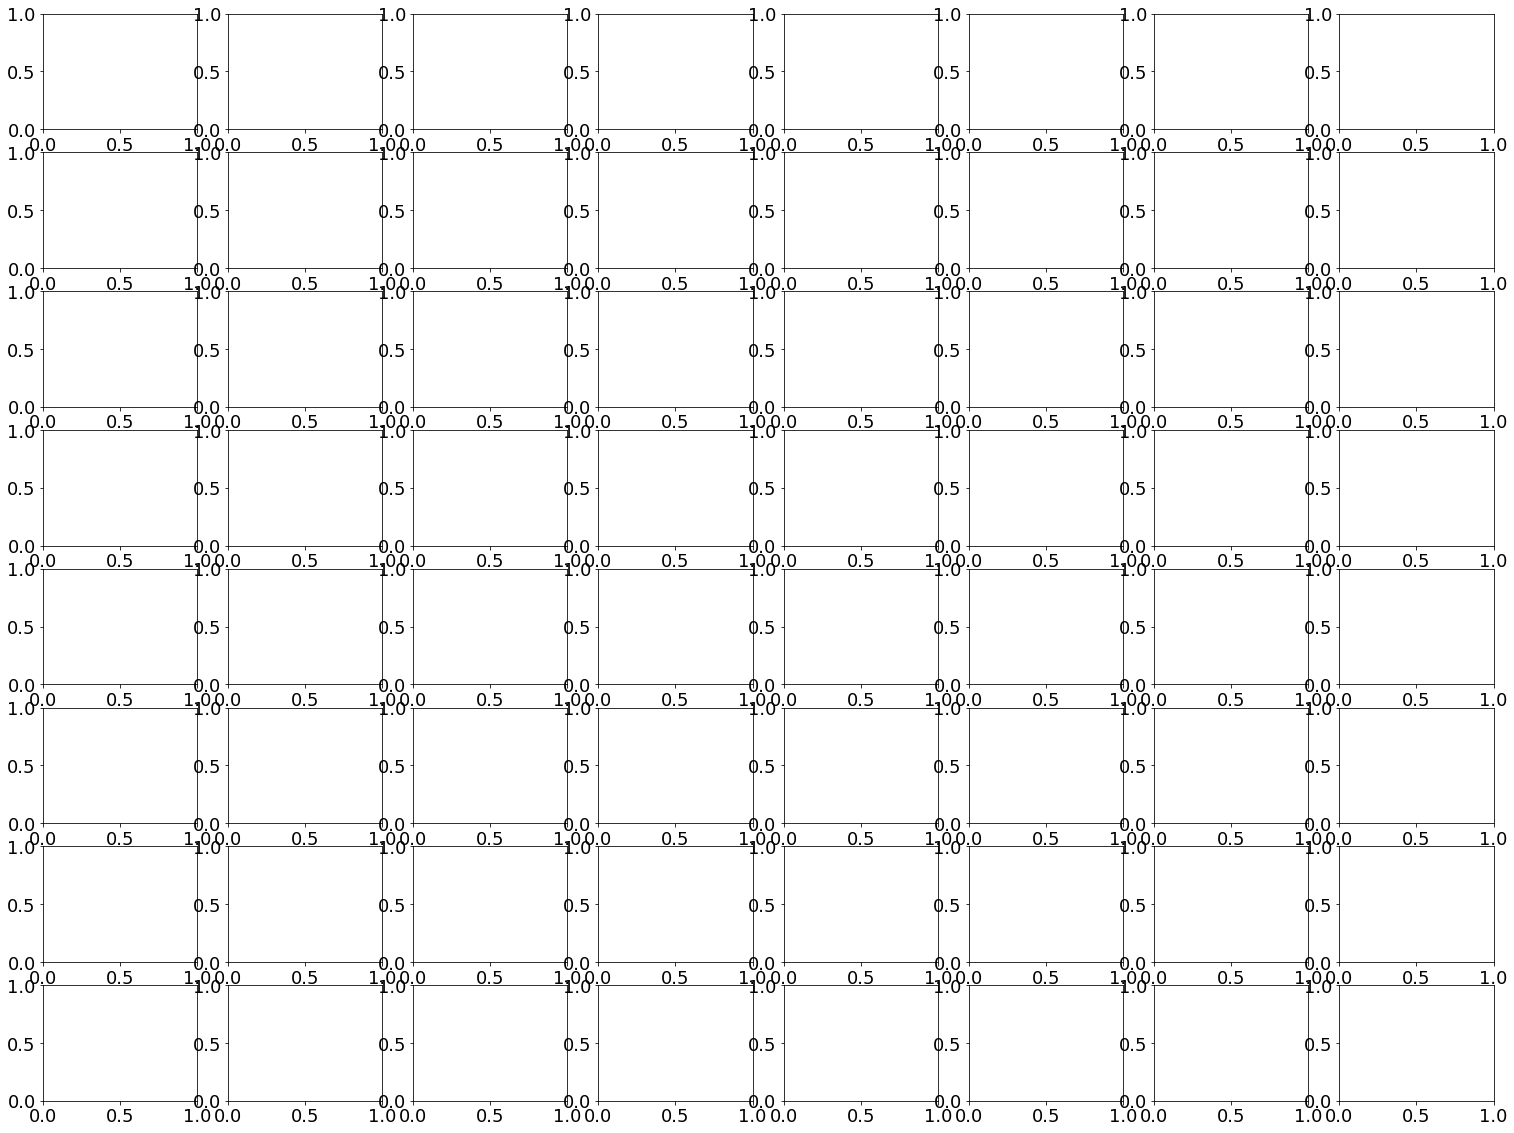

In [25]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_animal.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_animal.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_animal.loc[idx]['top_1'] == data_animal.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_animal.loc[idx]['top_1'] + ' | ' + data_animal.loc[idx]['model'], color=color)
    likelihood = data_animal.loc[idx]['likelihood']
    ax.set_ylabel(data_animal.loc[idx]['goal'], color=color)  
fig.set_facecolor(color='white')

#### Accuracy

In [26]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
for i, task in enumerate(args.tasks):
    df_acc = pd.DataFrame({model_name: {flip: f1_score(data_animal[(data_animal['model']==model_name) & (data_animal['task']==task) & (data_animal['flip']==flip) ]["top_1"], 
                                                                   data_animal[(data_animal['model']==model_name) & (data_animal['task']==task) & (data_animal['flip']==flip)]["goal"],
                                                      average = 'micro')
                                        for flip in flips} 
                           for model_name in model_animal})
    df_acc.loc[len(df_acc.index)] = test.iloc[i]
    temp_ = list(flips)
    temp_.append('Base')
    df_acc.index = temp_
    ax = df_acc.T.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=20)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='k', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=60)
    plt.legend(bbox_to_anchor=(1.15, .35), loc='lower right', fontsize=14)
    ax.set_title(f'Animal vs Artifact images f1 score for re-trained models, task: {task}', size=22)
    ax.set_ylabel('F1 score', size=20)
    ax.set_xlabel('Model', size=20);

IndexError: single positional indexer is out-of-bounds

### Artifact

#### Image display

Here is the images with the highest likelihood of the networks :

NameError: name 'data_artifact' is not defined

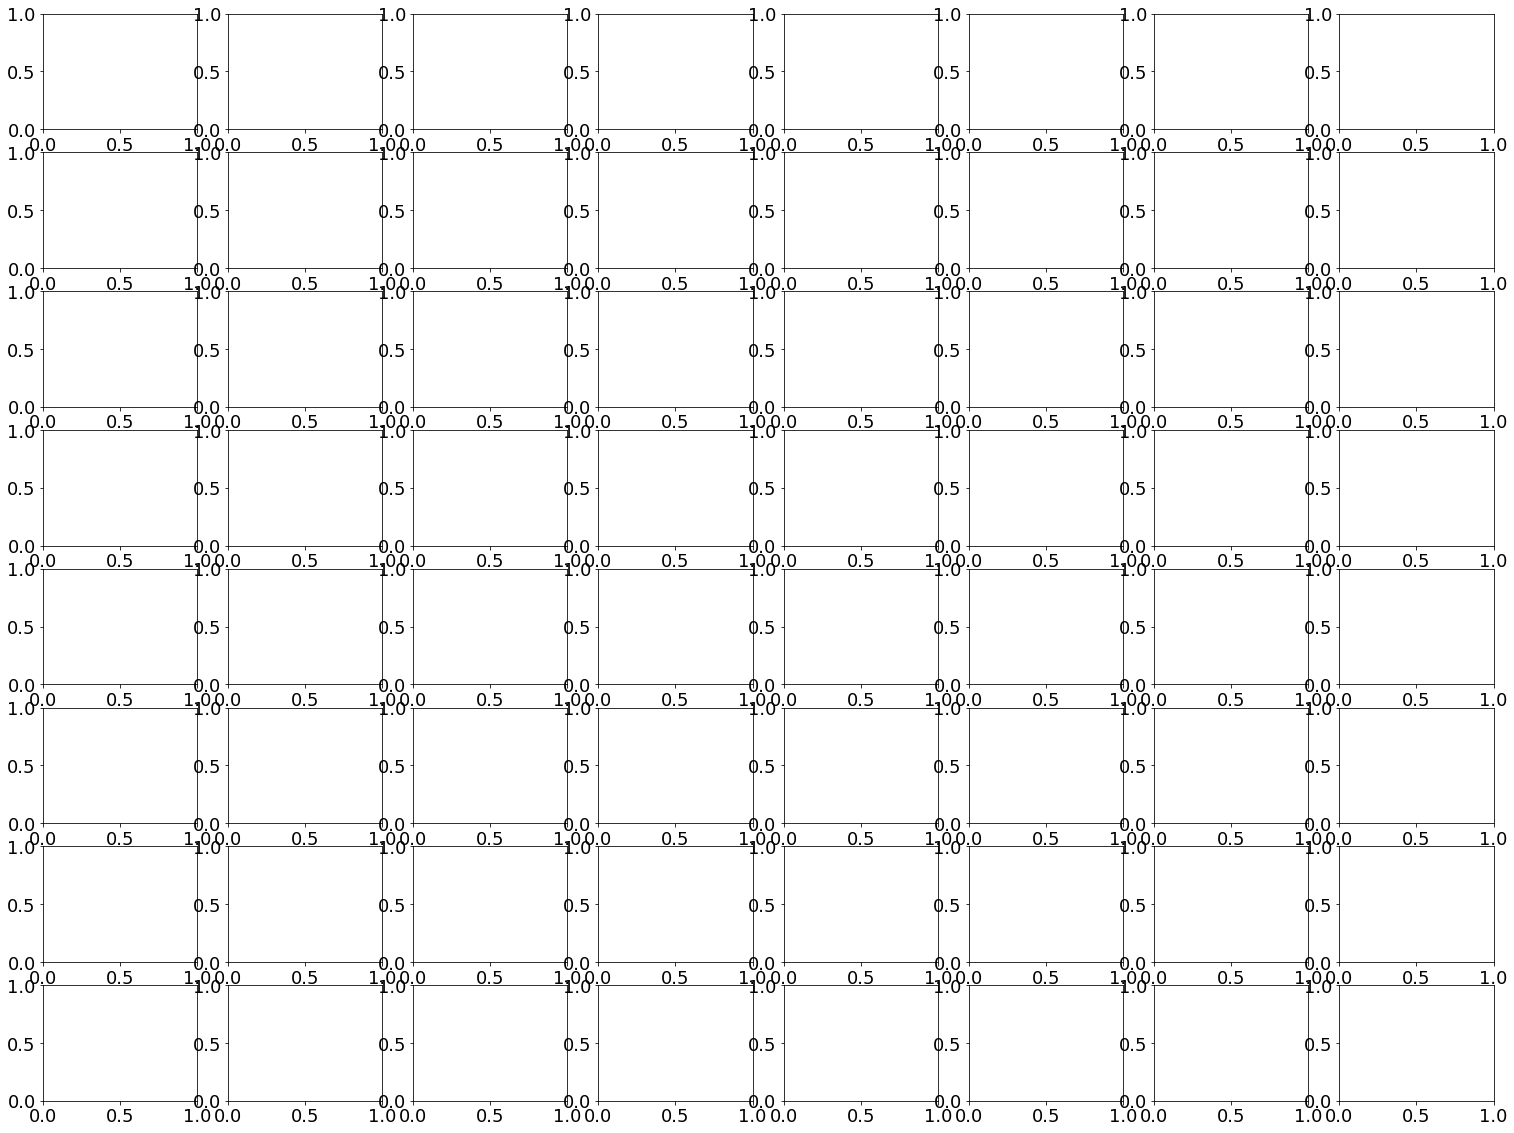

In [27]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_artifact.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_artifact.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_artifact.loc[idx]['top_1'] == data_artifact.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_artifact.loc[idx]['top_1'] + ' | ' + data_artifact.loc[idx]['model'], color=color)
    likelihood = data_artifact.loc[idx]['likelihood']
    ax.set_ylabel(data_artifact.loc[idx]['goal'], color=color) 
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'data_artifact' is not defined

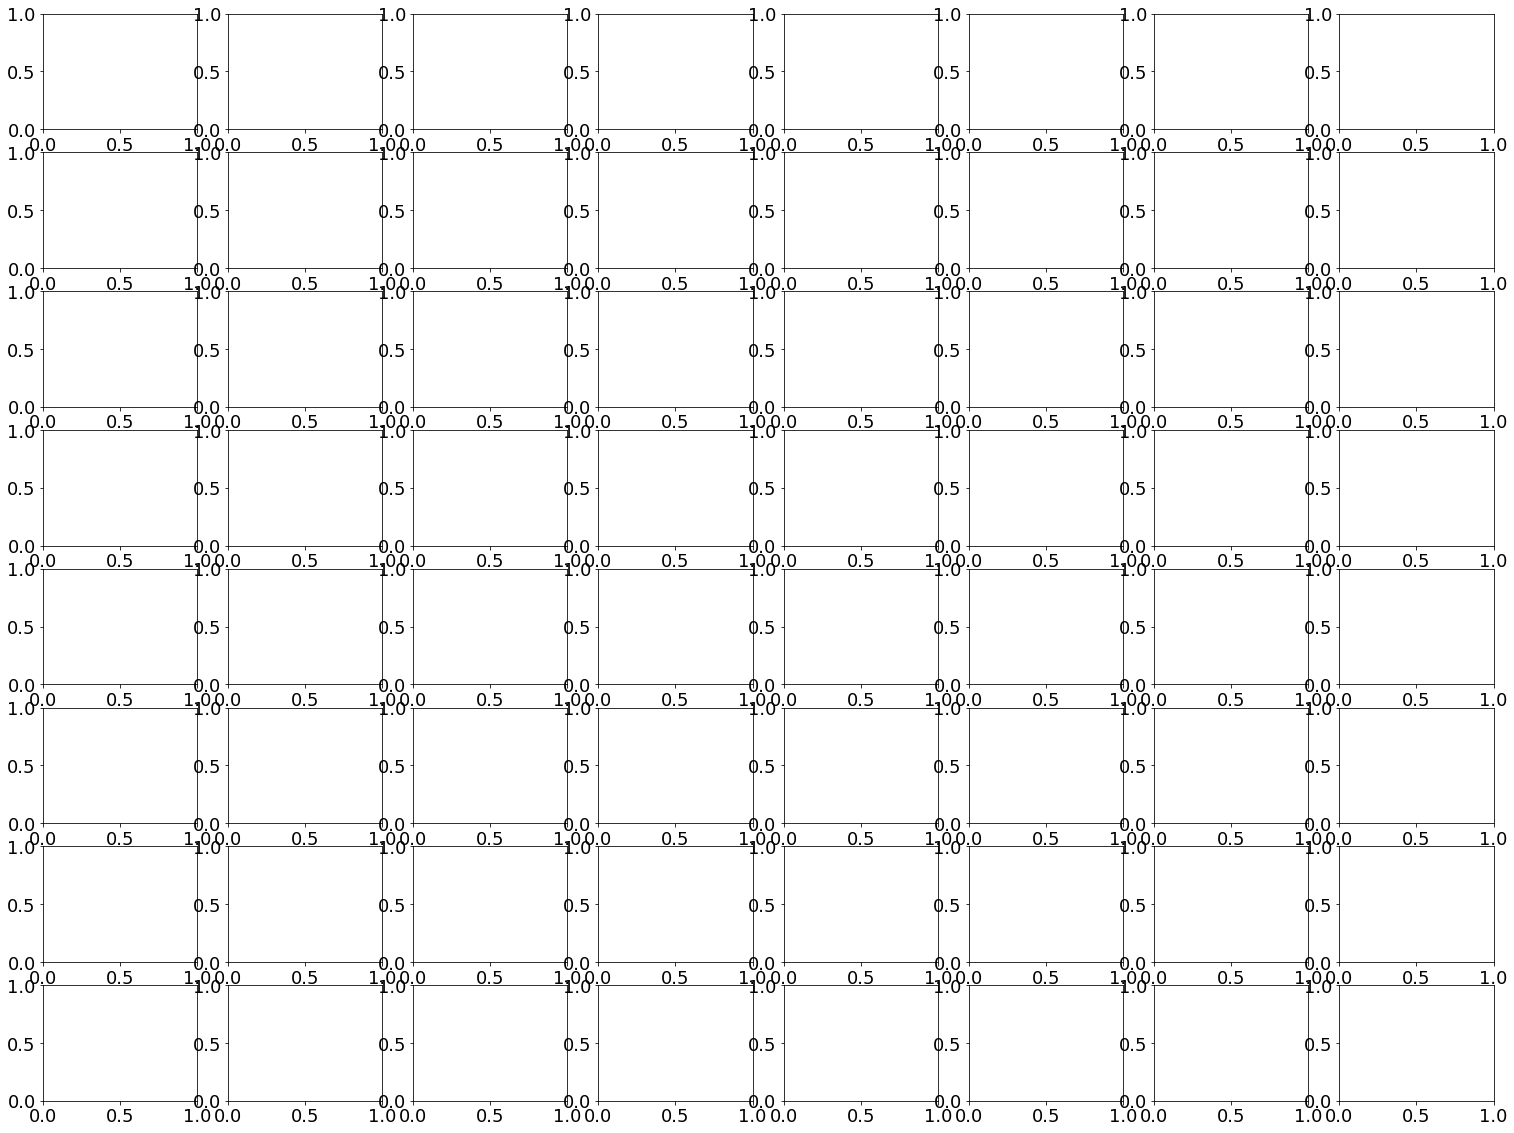

In [28]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_artifact.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_artifact.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_artifact.loc[idx]['top_1'] == data_artifact.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_artifact.loc[idx]['top_1'] + ' | ' + data_artifact.loc[idx]['model'], color=color)
    likelihood = data_artifact.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

#### Accuracy

In [29]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
for i,task in enumerate(args.tasks):
    df_acc = pd.DataFrame({model_name: {flip: f1_score(data_artifact[(data_artifact['model']==model_name) & (data_artifact['task']==task) & (data_artifact['flip']==flip) ]["top_1"], 
                                                                   data_artifact[(data_artifact['model']==model_name) & (data_artifact['task']==task) & (data_artifact['flip']==flip)]["goal"],
                                                      average = 'micro')
                                        for flip in flips} 
                           for model_name in model_artifact})
    df_acc.loc[len(df_acc.index)] = test_.iloc[i]
    temp_ = list(flips)
    temp_.append('Base')
    df_acc.index = temp_
    ax = df_acc.T.plot.bar(rot=30, figsize=(fig_width, fig_width//4), fontsize=20)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='k', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=60)
    plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=14)
    ax.set_title(f'Animal vs Artifact images f1 score for re-trained models, task: {task}', size=22)
    ax.set_ylabel('F1 score', size=20)
    ax.set_xlabel('Model', size=20);

NameError: name 'test_' is not defined

### Summary

#### Computation Time

NameError: name 'df_flip' is not defined

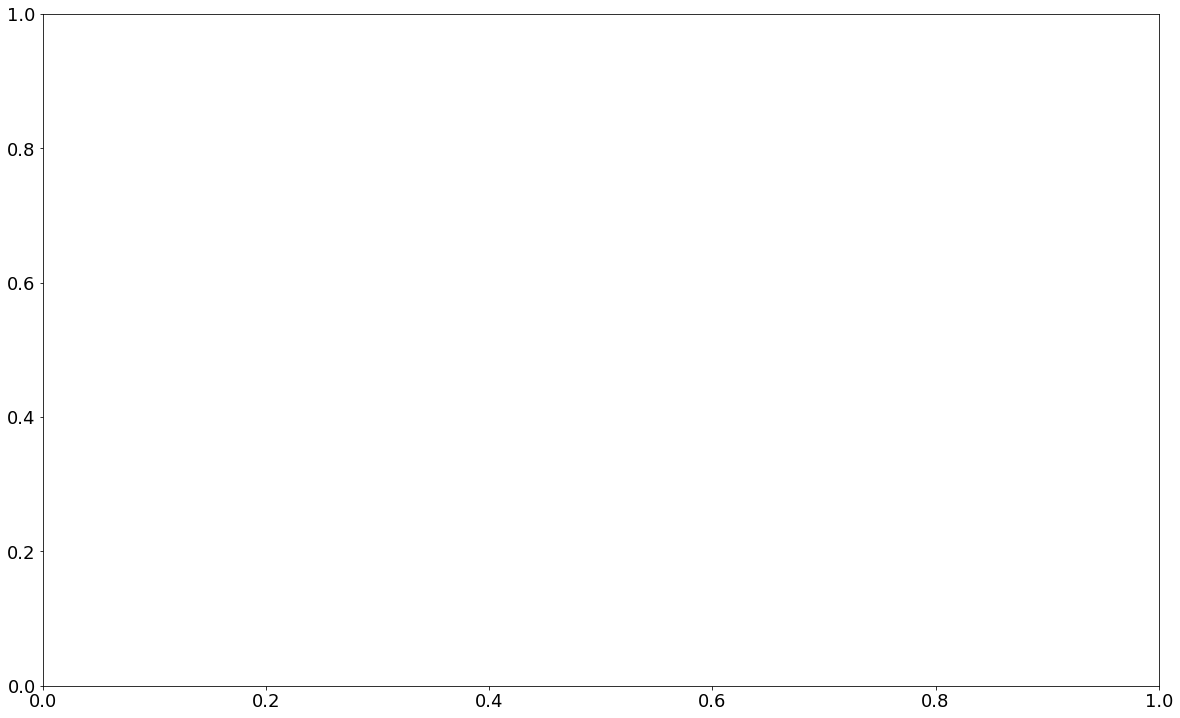

In [30]:
fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi))
for color, model_name in zip(colors, models_vgg.keys()):
    axs = sns.violinplot(x="flip", y="time", data=df_flip, inner="quartile", hue='model')
    axs.set_title('Processing time (s) for each network at different image size. Processed on : ' + args.HOST + '_' + str(df_flip['device_type'][0]), size = 20)
    axs.set_ylabel('Computation time (s)', size=18)
    axs.set_xlabel('Image size', size=18)
    axs.set_yscale('log')
    axs.grid(which='both', axis='y')
    for side in ['top', 'right'] :axs.spines[side].set_visible(False)
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc='upper center', fontsize=16);

#### Accuracy comparison for all the models

In [31]:
for task in args.tasks:
    df_acc = pd.DataFrame({model_name: {flip: f1_score(df_flip[(df_flip['model']==model_name) & (df_flip['task']==task) & (df_flip['flip']==flip) ]["top_1"], 
                                                                   df_flip[(df_flip['model']==model_name) & (df_flip['task']==task) & (df_flip['flip']==flip)]["goal"],
                                                      average = 'micro')
                                        for flip in flips} 
                           for model_name in models_vgg})

    ax = df_acc.T.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=20)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='k', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
    plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=14)
    ax.set_title(f'Animal vs Artifact images f1 score for re-trained models, task: {task}', size=22)
    ax.set_ylabel('F1 score', size=20)
    ax.set_xlabel('Model', size=20);

NameError: name 'df_flip' is not defined

#### Conclusion

We tested the Vgg Gen network on the ImageNet dataset with either a vertical or horizontal reflection applied on the input. The networks keeps a good mean accuracy on the flipped dataset (about 95%).

<a id="exp3"></a>
## Experiment 3: Image processing and recognition for differents resolutions :

Let's now study that same likelihood indicators at different image resolutions.

In [32]:
scriptname = 'UltraFastCat/experiment_downsample.py'

In [33]:
%%writefile {scriptname}

#import model's script and set the output file
from experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

filename = f'results/{datetag}_results_downsample_{args.HOST}.json'
print(f'{filename=}')

def main():
    if os.path.isfile(filename):
        df_downsample = pd.read_json(filename)
    else:
        i_trial = 0
        df_downsample = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'image_size', 'device_type'])   
        # image preprocessing
        for image_size in args.image_sizes:
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size, batch_size=1)
            print(f'Résolution de {image_size=}')
            for task in args.tasks:
                print(task)
                for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                    data, label, = data.to(device), label.to(device)
                    for model_name in models_vgg:
                        model = models_vgg[model_name].to(device)
                        with torch.no_grad():
                            goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                            model_task = 'animal' if 'animal' in model_name else 'artifact'
                            tic = time.time()
                            out = model(data).squeeze(0)
                            if model_name == 'vgg_16':
                                temp_, likelihood = 0, 0
                                model_task = 'Imagenet_challenge'
                                percentage = torch.nn.functional.softmax(out, dim=0) * 100
                                for idx in np.arange(0,1000,1):
                                    if idx in match[task]:
                                        likelihood += math.exp(percentage[idx].item())
                                    else:
                                        temp_ += math.exp(percentage[idx].item())  
                                likelihood = likelihood/temp_
                            else:
                                likelihood = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                            top_1 = 'target' if likelihood>50 else 'distractor'
                            elapsed_time = time.time() - tic 
                        df_downsample.loc[i_trial] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                               'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type, 'image_size':image_size}
                        #print(f'The {model_name} model categorize {model_task} with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                        i_trial += 1

            df_downsample.to_json(filename)
main()

Overwriting UltraFastCat/experiment_downsample.py


In [34]:
%run -int {scriptname}

Re-training pretrained model... models/re-trained_vgg16_gen_animal.pt
Traning vgg16_gen_animal, image_size = 256, p (Grayscale) = 0


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 5.93 GiB total capacity; 962.08 MiB already allocated; 44.00 MiB free; 972.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


IPython CPU timings (estimated):
  User   :       1.56 s.
  System :       0.39 s.
Wall time:       1.69 s.


<Figure size 432x288 with 0 Axes>

In [35]:
datetag = '2021-12-06'
model_animal = []
model_artifact = []
filename = f'results/{datetag}_results_downsample_{args.HOST}.json'
df_downsample = pd.read_json(filename)
data_animal = df_downsample.loc[df_downsample['model_task'] == 'animal']
data_artifact = df_downsample.loc[df_downsample['model_task'] == 'artifact']
for model in models_vgg:
    model_animal.append(model) if 'animal' in model else model_artifact.append(model)

ValueError: Expected object or value

### Animal

#### Image display 

Here is the images with the highest likelihood of the networks :

NameError: name 'data_animal' is not defined

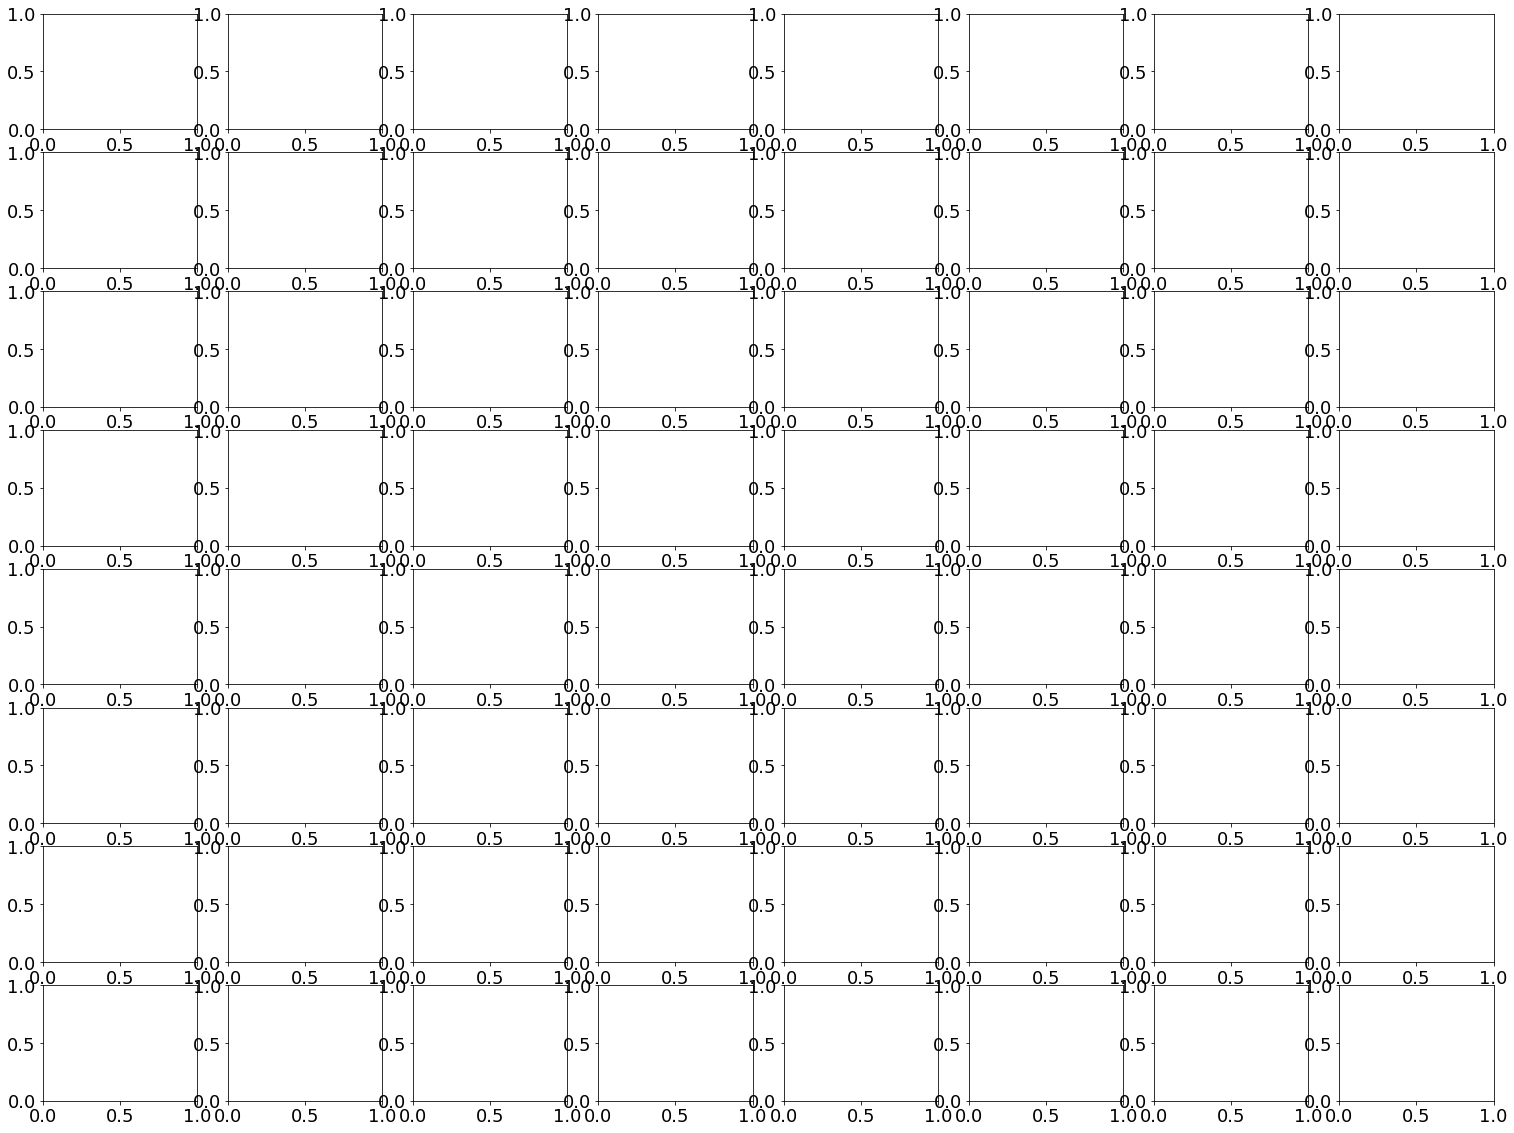

In [36]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_animal.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_animal.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_animal.loc[idx]['top_1'] == data_animal.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_animal.loc[idx]['top_1'] + ' | ' + data_animal.loc[idx]['model'] + ' | ' + str(data_animal.loc[idx]['image_size']), color=color)
    likelihood = data_animal.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'data_animal' is not defined

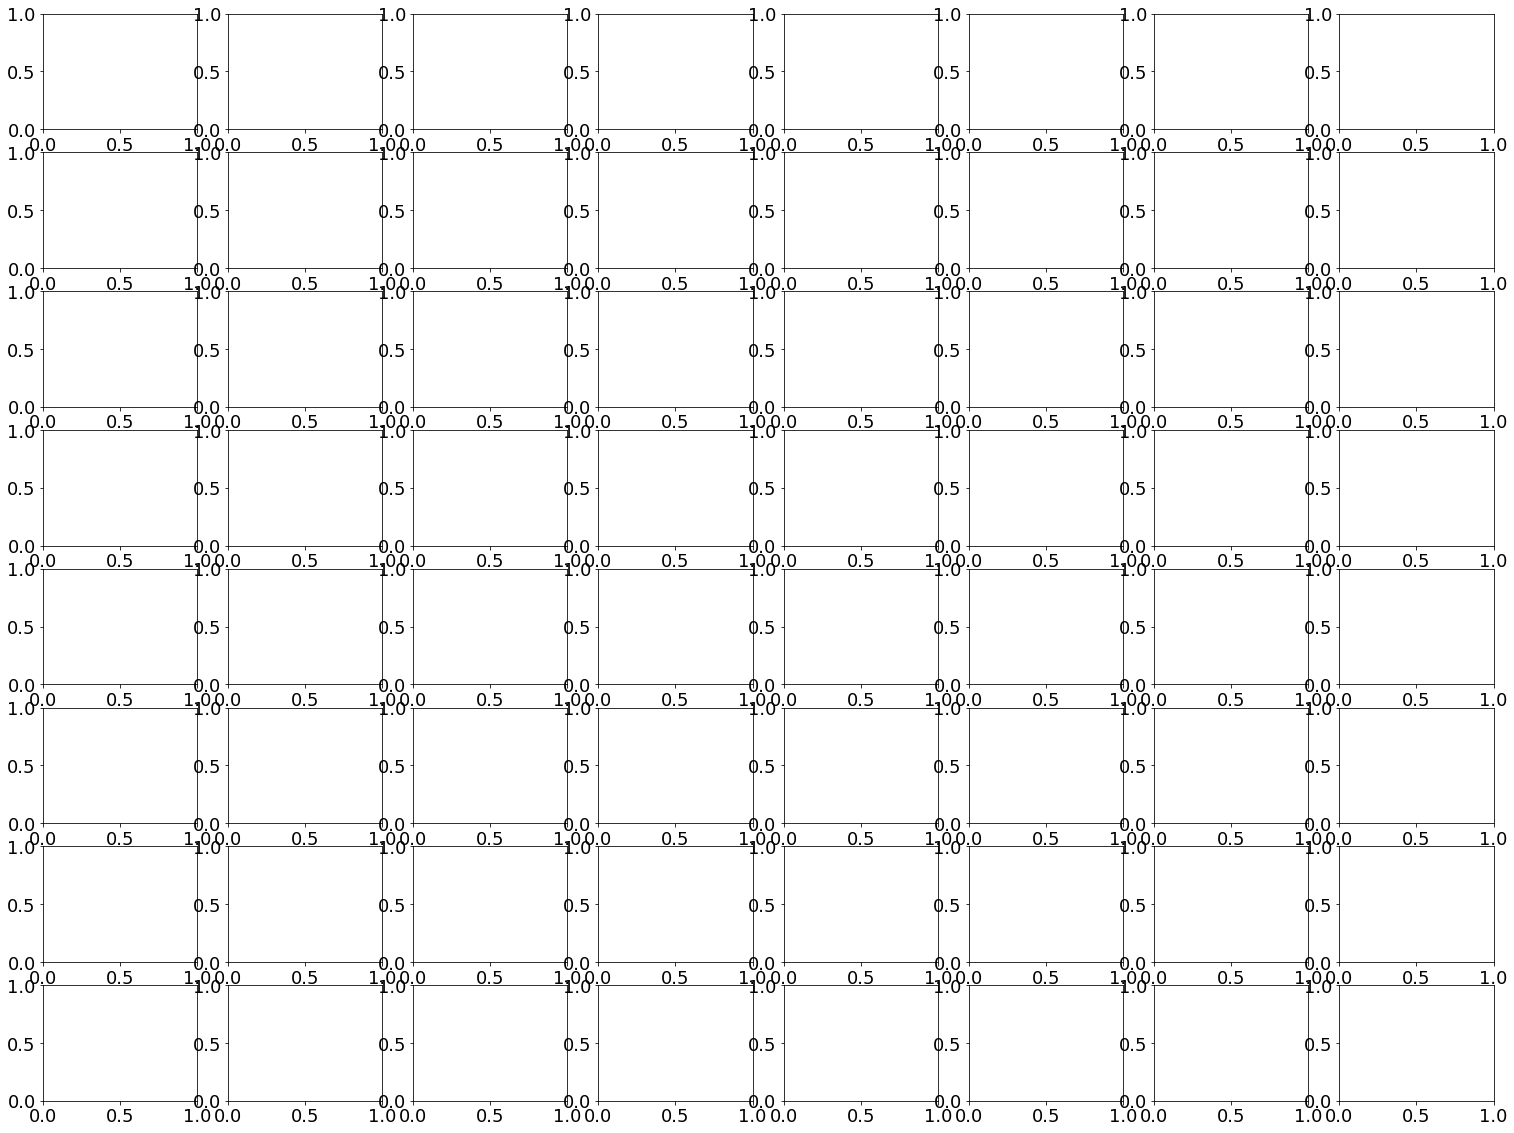

In [37]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_animal.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_animal.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_animal.loc[idx]['top_1'] == data_animal.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_animal.loc[idx]['top_1'] + ' | ' + data_animal.loc[idx]['model'] + ' | ' + str(data_animal.loc[idx]['image_size']), color=color)
    likelihood = data_animal.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

#### Accuracy 

In [38]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
for task in args.tasks:
    df_acc = pd.DataFrame({model_name: {image_size: f1_score(data_animal[(data_animal['model']==model_name) & (data_animal['task']==task) & (data_animal['image_size']==image_size) ]["top_1"], 
                                                                   data_animal[(data_animal['model']==model_name) & (data_animal['task']==task) & (data_animal['image_size']==image_size)]["goal"],
                                                      average = 'micro')
                                        for image_size in args.image_sizes} 
                           for model_name in model_animal})

    ax = df_acc.T.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=20)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=60)
    plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=14)
    ax.set_title(f'Animal vs Artifact images f1 score for re-trained models, task: {task}', size=22)
    ax.set_ylabel('F1 score', size=20)
    ax.set_xlabel('Model', size=20);

TypeError: no numeric data to plot

### Artifact

#### Image display :

Here is the images with the highest likelihood of the networks :

NameError: name 'data_artifact' is not defined

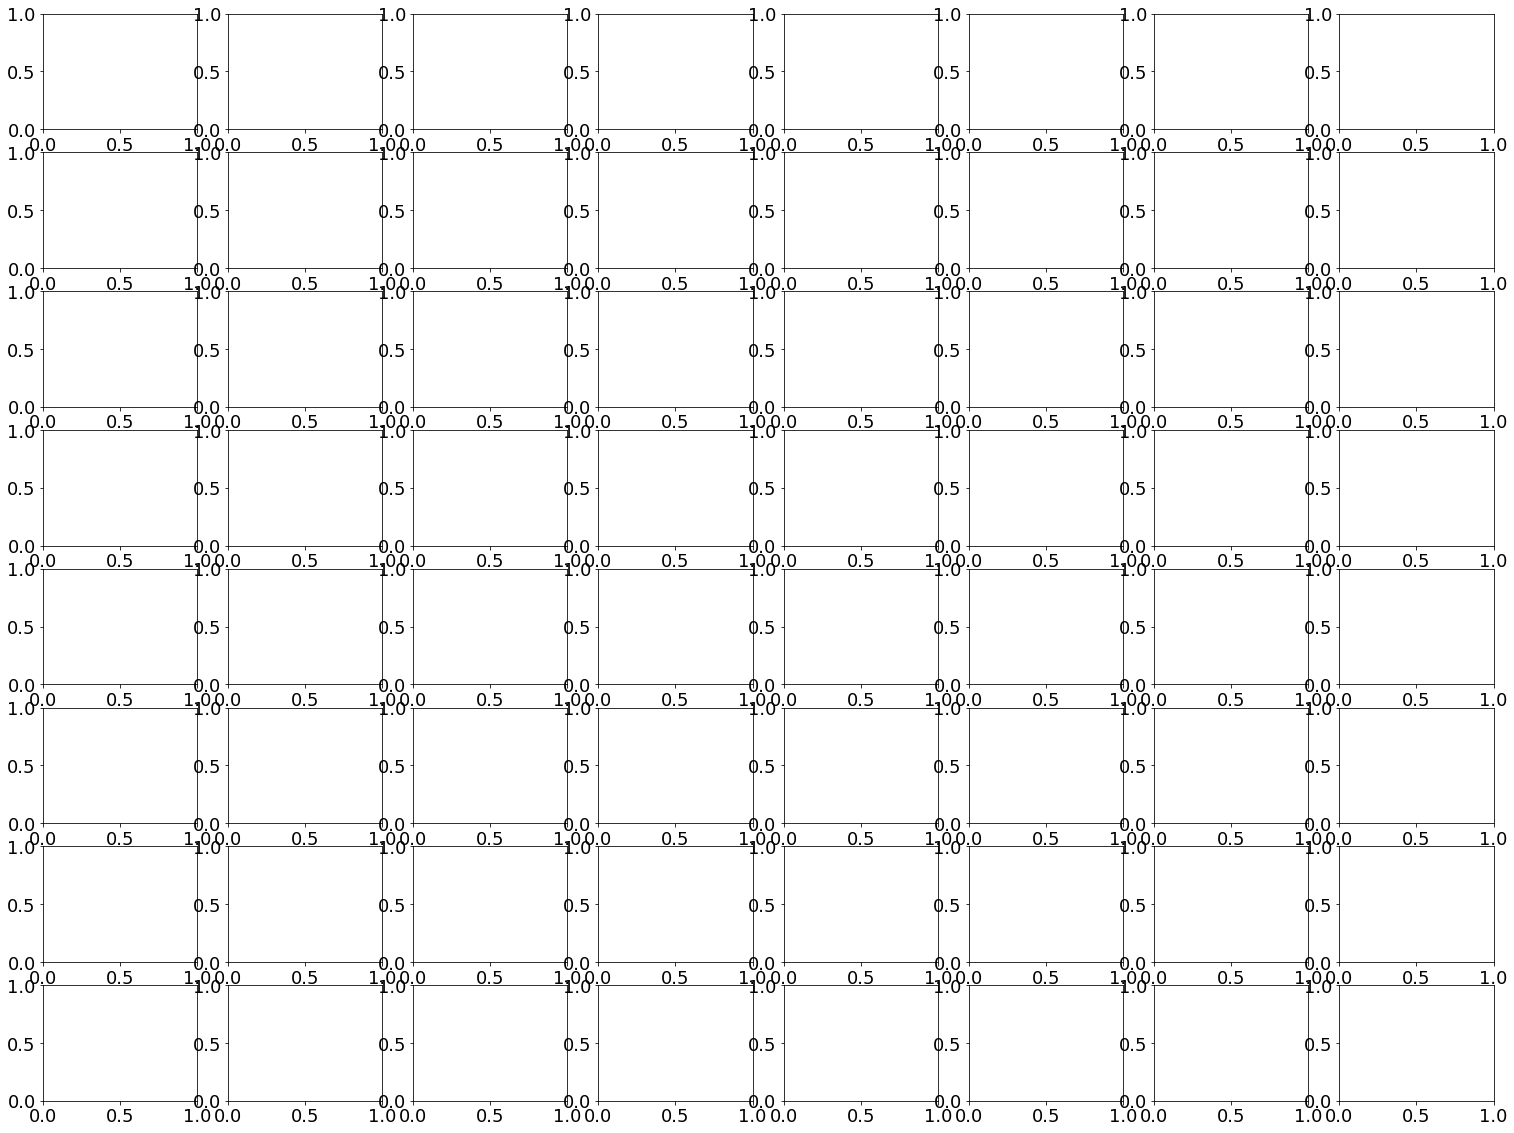

In [39]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_artifact.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['artifact']['test'].imgs[data_artifact.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_artifact.loc[idx]['top_1'] == data_artifact.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_artifact.loc[idx]['top_1'] + ' | ' + data_artifact.loc[idx]['model'] + ' | ' + str(data_artifact.loc[idx]['image_size']), color=color)
    likelihood = data_artifact.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'data_artifact' is not defined

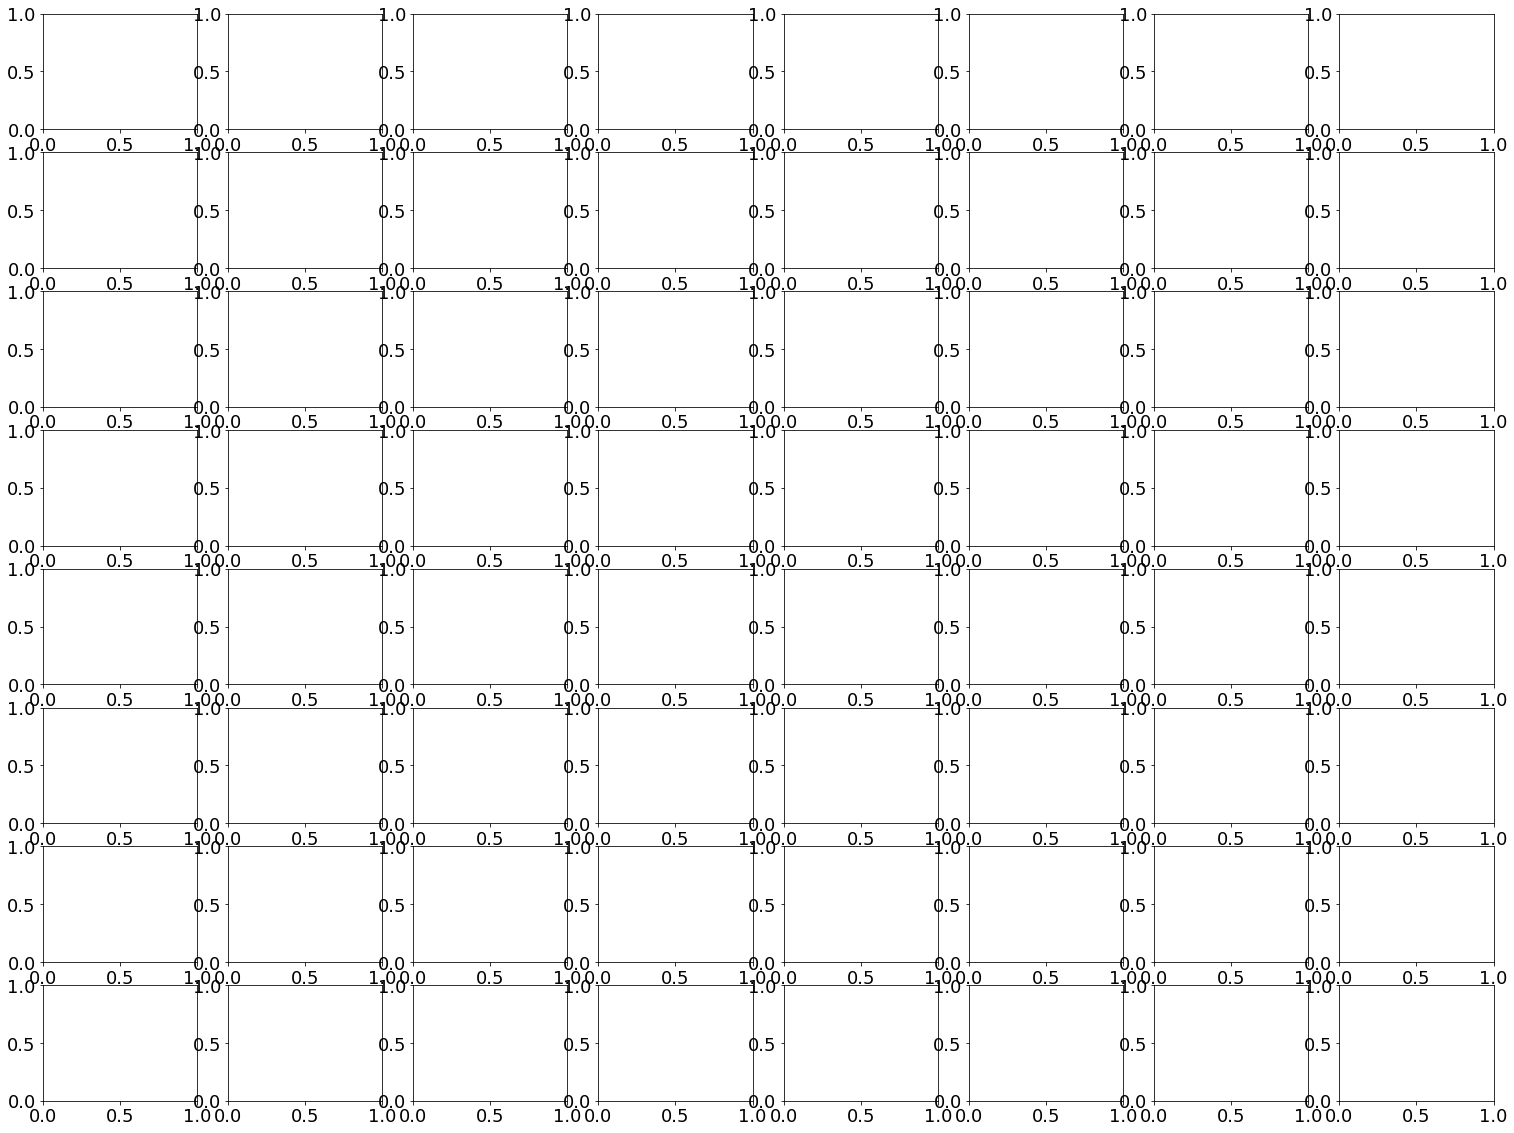

In [40]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_artifact.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['artifact']['test'].imgs[data_artifact.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_artifact.loc[idx]['top_1'] == data_artifact.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_artifact.loc[idx]['top_1'] + ' | ' + data_artifact.loc[idx]['model'] + ' | ' + str(data_artifact.loc[idx]['image_size']), color=color)
    likelihood = data_artifact.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

#### Accuracy : 

In [41]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
for task in args.tasks:
    df_acc = pd.DataFrame({model_name: {image_size: f1_score(data_artifact[(data_artifact['model']==model_name) & (data_artifact['task']==task) & (data_artifact['image_size']==image_size) ]["top_1"], 
                                                                   data_artifact[(data_artifact['model']==model_name) & (data_artifact['task']==task) & (data_artifact['image_size']==image_size)]["goal"],
                                                      average = 'micro')
                                       for image_size in args.image_sizes} 
                           for model_name in model_artifact})

    ax = df_acc.T.plot.bar(rot=30, figsize=(fig_width, fig_width//4), fontsize=20)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=60)
    plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=14)
    ax.set_title(f'Animal vs Artifact images f1 score for re-trained models, task: {task}', size=22)
    ax.set_ylabel('F1 score', size=20)
    ax.set_xlabel('Model', size=20);

TypeError: no numeric data to plot

### Summary

#### Computation time

NameError: name 'df_downsample' is not defined

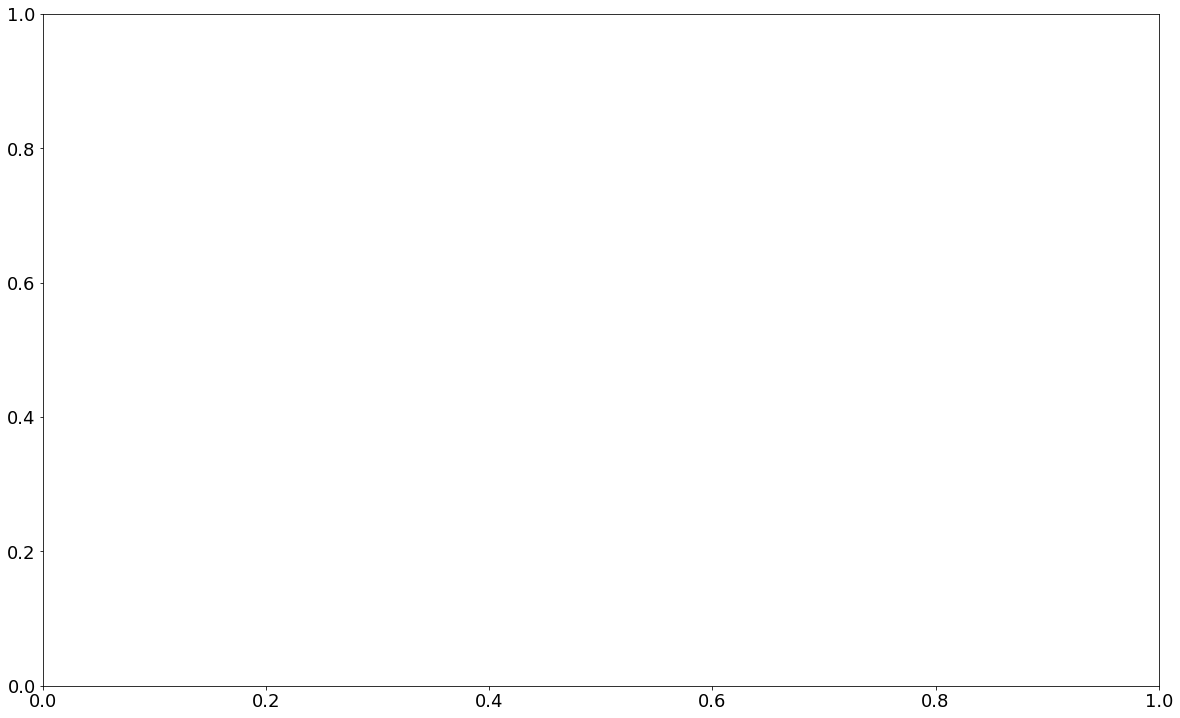

In [42]:
fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi))
for color, model_name in zip(colors, models_vgg):
    axs = sns.violinplot(x="image_size", y="time", data=df_downsample, inner="quartile", hue='model')
    axs.set_title('Processing time (s) for each network at different image size. Processed on : ' + args.HOST + '_' + str(df_downsample['device_type'][0]), size = 20)
    axs.set_ylabel('Computation time (s)', size=18)
    axs.set_xlabel('Image size', size=18)
    axs.set_yscale('log')
    axs.grid(which='both', axis='y')
    for side in ['top', 'right'] :axs.spines[side].set_visible(False)
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc='upper center', fontsize=16);

#### Accuracy comparison for all the models

In [43]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
for task in args.tasks:
    df_acc = pd.DataFrame({model_name: {image_size: f1_score(df_downsample[(df_downsample['model']==model_name) & (df_downsample['task']==task) & (df_downsample['image_size']==image_size) ]["top_1"], 
                                                                   df_downsample[(df_downsample['model']==model_name) & (df_downsample['task']==task) & (df_downsample['image_size']==image_size)]["goal"],
                                                      average = 'micro')
                                        for image_size in args.image_sizes} 
                           for model_name in models_vgg})

    ax = df_acc.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=20)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
    plt.legend(bbox_to_anchor=(1.2, .3), loc='lower right', fontsize=14)
    ax.set_title(f'Animal vs Artifact images f1 score for re-trained models, task: {task}', size=22)
    ax.set_ylabel('F1 score', size=20)
    ax.set_xlabel('Model', size=20);

NameError: name 'df_downsample' is not defined

In [44]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
for task in args.tasks:
    df_acc = pd.DataFrame({model_name: {image_size: f1_score(df_downsample[(df_downsample['model']==model_name) & (df_downsample['task']==task) & (df_downsample['image_size']==image_size) ]["top_1"], 
                                                                   df_downsample[(df_downsample['model']==model_name) & (df_downsample['task']==task) & (df_downsample['image_size']==image_size)]["goal"],
                                                      average = 'micro')
                                        for image_size in args.image_sizes} 
                           for model_name in models_vgg})

    ax = df_acc.T.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=20)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
    plt.legend(bbox_to_anchor=(1.2, .3), loc='lower right', fontsize=14)
    ax.set_title(f'Animal vs Artifact images f1 score for re-trained models, task: {task}', size=22)
    ax.set_ylabel('F1 score', size=20)
    ax.set_xlabel('Model', size=20);

NameError: name 'df_downsample' is not defined

#### Conclusion

We found similar results as in flip transformation when testing  the netxworks on our dataset with different image sizes [experiment 3](#exp3), even if the network train on such transformation seems more robust to this transformation than the others the networks keeps a good mean accuracy on the whole downscaling dataset. 

<a id="exp4"></a>
## Experiment 4: Image processing and recognition on grayscale images :

Again, same likelihood indicators but now with a grayscale transformation.

In [45]:
scriptname = 'UltraFastCat/experiment_grayscale.py'

In [46]:
%%writefile {scriptname}

#import model's script and set the output file

#from UltraFastCat.model import *
from experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

filename = f'results/{datetag}_results_3_{args.HOST}.json'
print(f'{filename=}')

def main():
    if os.path.isfile(filename):
        df_gray = pd.read_json(filename)
    else:
        i_trial = 0
        df_gray = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
            # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1, p=1)
        for task in args.tasks:
            pprint(task)
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data, label = data.to(device), label.to(device)
                for model_name in models_vgg:
                    model = models_vgg[model_name].to(device)
                    with torch.no_grad():
                        goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                        model_task = 'animal' if 'animal' in model_name else 'artifact'
                        tic = time.time()
                        out = model(data).squeeze(0)
                        if model_name == 'vgg_16':
                            temp_, likelihood = 0, 0
                            model_task = 'Imagenet_challenge'
                            percentage = torch.nn.functional.softmax(out, dim=0) * 100
                            for idx in np.arange(0,1000,1):
                                if idx in match[task]:
                                    likelihood += math.exp(percentage[idx].item())
                                else:
                                    temp_ += math.exp(percentage[idx].item())  
                            likelihood = likelihood/temp_
                        else:
                            likelihood = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                        top_1 = 'target' if percentage>50 else 'distractor'
                        elapsed_time = time.time() - tic
                    df_gray.loc[i_trial] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                          'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                    print(f'The {model_name} model categorize {model_task} with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                    i_trial += 1
        df_gray.to_json(filename)
main()     

Overwriting UltraFastCat/experiment_grayscale.py


In [47]:
%run -int {scriptname}

Re-training pretrained model... models/re-trained_vgg16_gen_animal.pt
Traning vgg16_gen_animal, image_size = 256, p (Grayscale) = 0


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 5.93 GiB total capacity; 962.08 MiB already allocated; 44.00 MiB free; 972.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


IPython CPU timings (estimated):
  User   :       1.62 s.
  System :       0.42 s.
Wall time:       1.73 s.


<Figure size 432x288 with 0 Axes>

In [48]:
datetag = '2021-12-09'
model_animal = []
model_artifact = []
filename = f'results/{datetag}_results_3_{args.HOST}.json'
df_gray = pd.read_json(filename)
data_animal = df_gray.loc[df_gray['model_task'] == 'animal']
data_artifact = df_gray.loc[df_gray['model_task'] == 'artifact']
for model in models_vgg:
    model_animal.append(model) if 'animal' in model else model_artifact.append(model)

ValueError: Expected object or value

### Animal

#### Image display

Here is the images with the highest likelihood of the networks :

NameError: name 'data_animal' is not defined

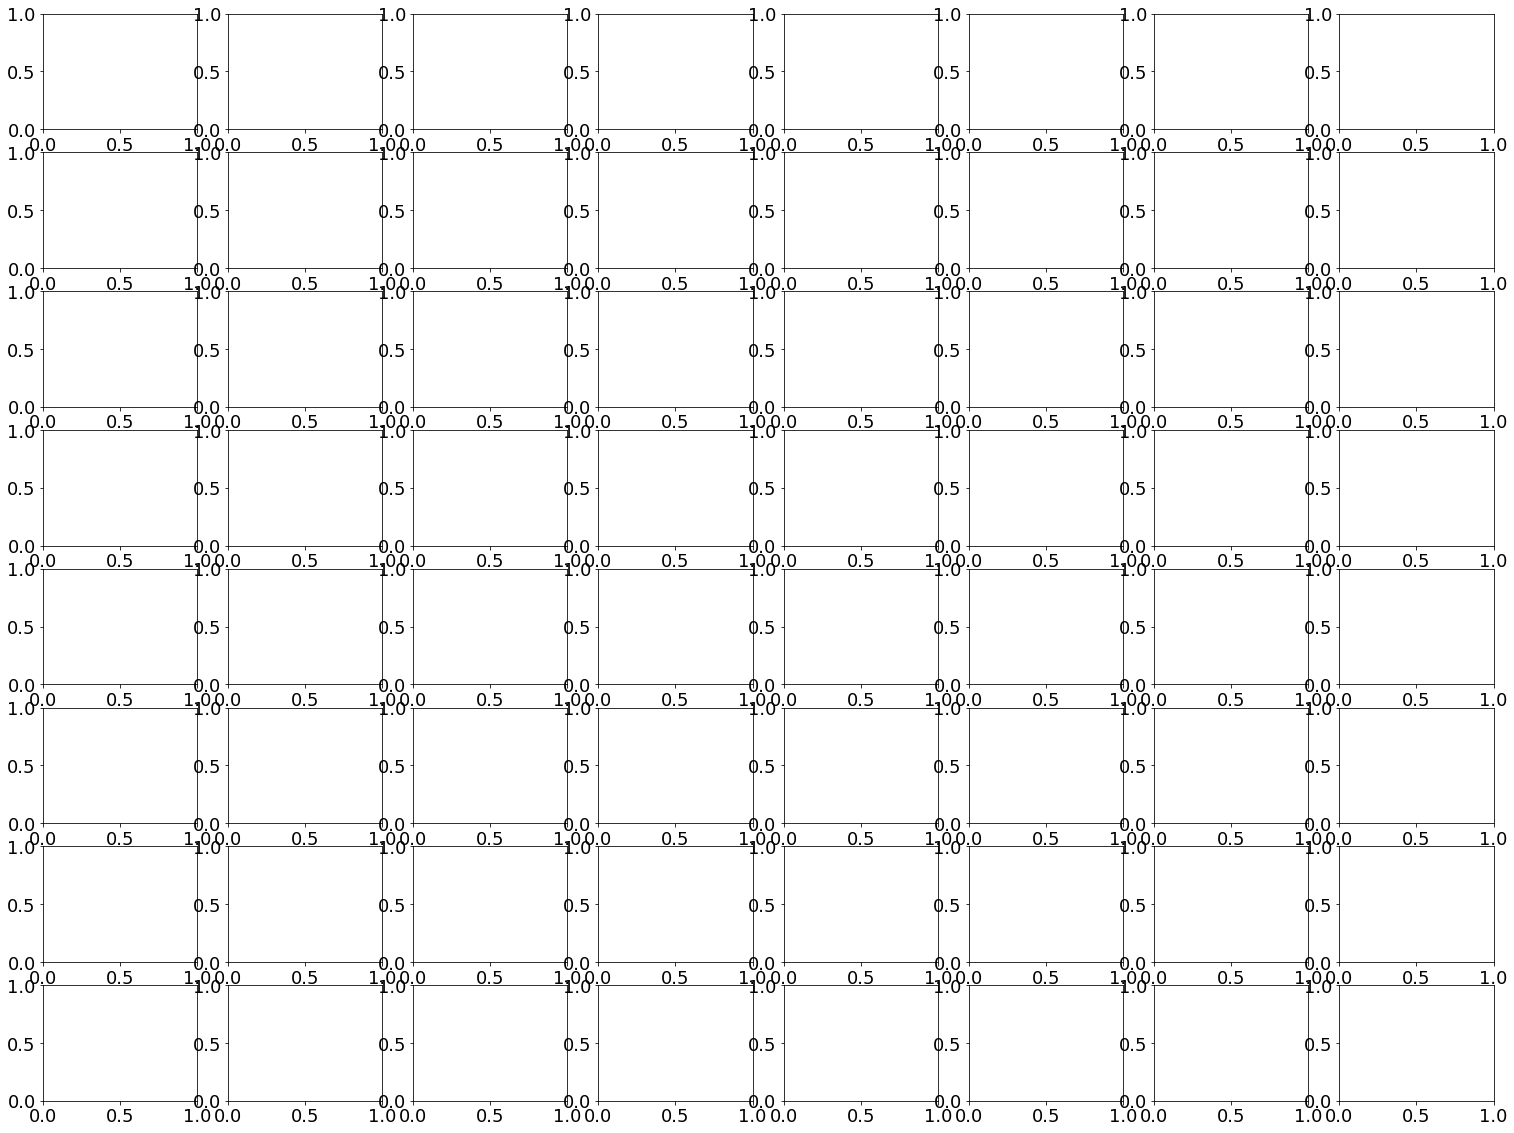

In [49]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_animal.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_animal.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address, pilmode="L"), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_animal.loc[idx]['top_1'] == data_animal.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_animal.loc[idx]['top_1'] + ' | ' + data_animal.loc[idx]['model'], color=color)
    likelihood = data_animal.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'data_animal' is not defined

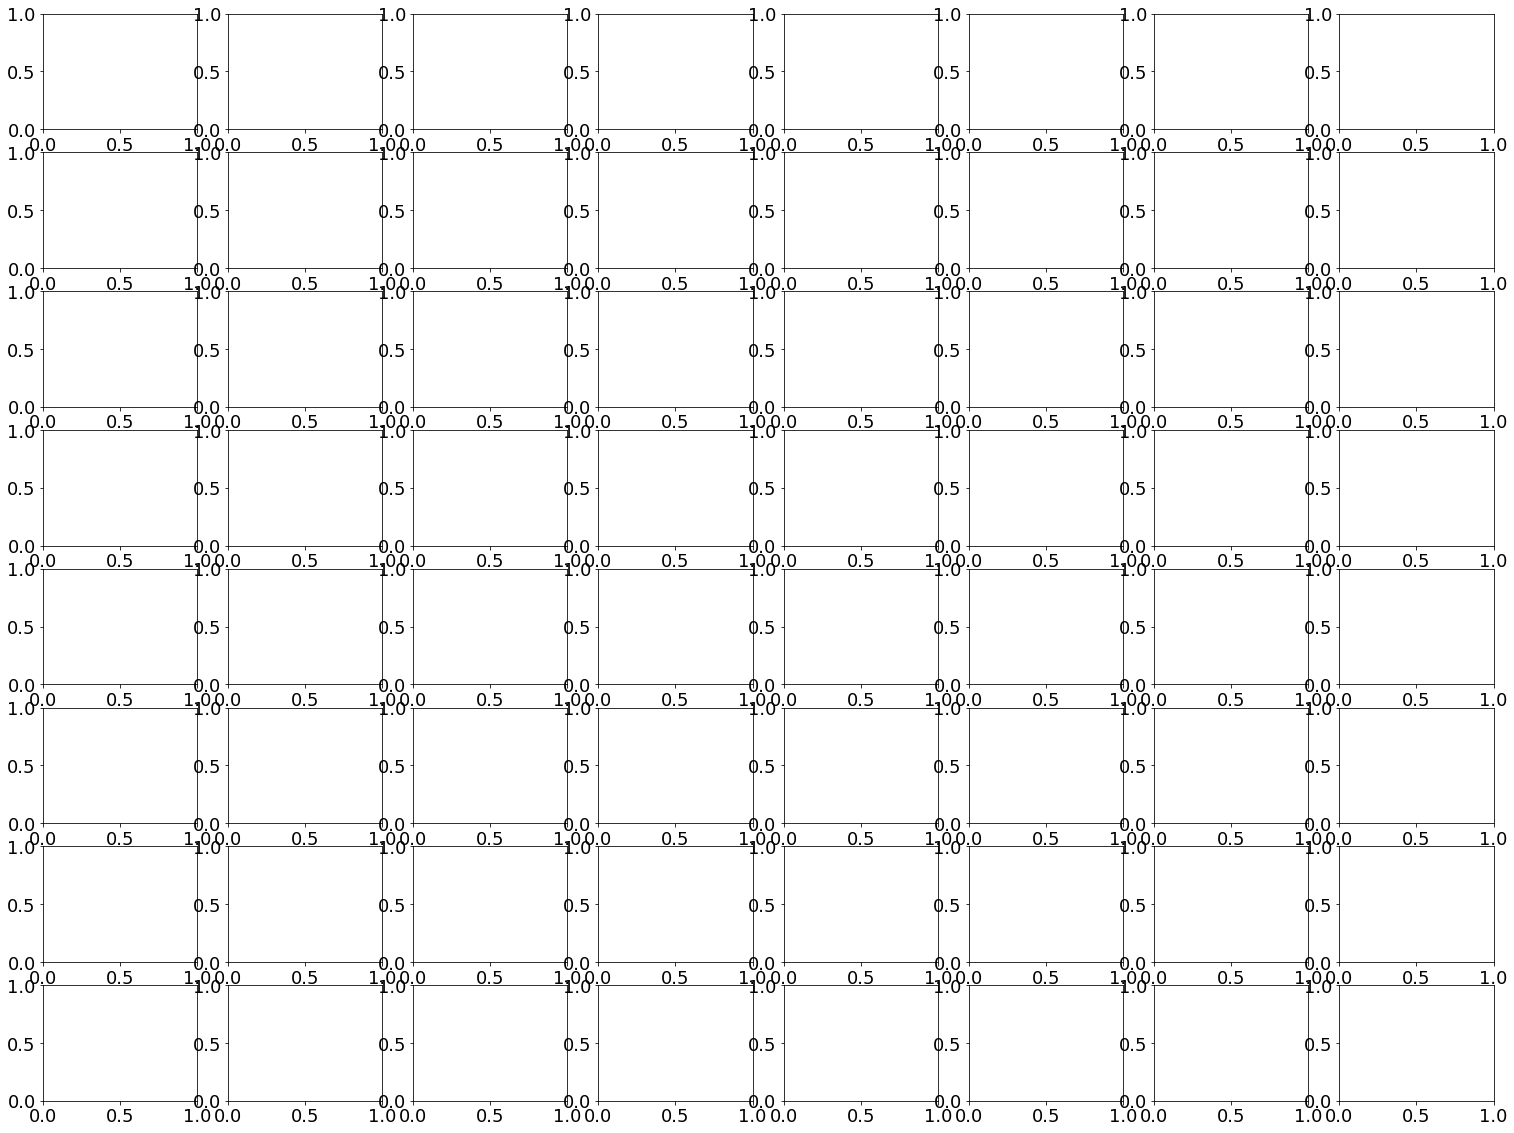

In [50]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_animal.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_animal.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address, pilmode="L"), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_animal.loc[idx]['top_1'] == data_animal.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_animal.loc[idx]['top_1'] + ' | ' + data_animal.loc[idx]['model'], color=color)
    likelihood = data_animal.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color) 
fig.set_facecolor(color='white')

#### Accuracy

In [51]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
df_acc = pd.DataFrame({model_name: {task: f1_score(data_animal[(data_animal['model']==model_name) & (data_animal['task']==task)]["top_1"], 
                                                               data_animal[(data_animal['model']==model_name) & (data_animal['task']==task)]["goal"],
                                                  average = 'micro')
                                    for task in args.tasks} 
                       for model_name in model_animal})
test = df_acc
ax = df_acc.T.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=20)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=60)
plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=18)
ax.set_title(f'Animal vs Artifact images f1 score for re-trained models', size=22)
ax.set_ylabel('Accuracy', size=20)
ax.set_xlabel('Model', size=20);

TypeError: no numeric data to plot

### Artifact

#### Image display

Here is the images with the highest likelihood of the networks :

NameError: name 'data_artifact' is not defined

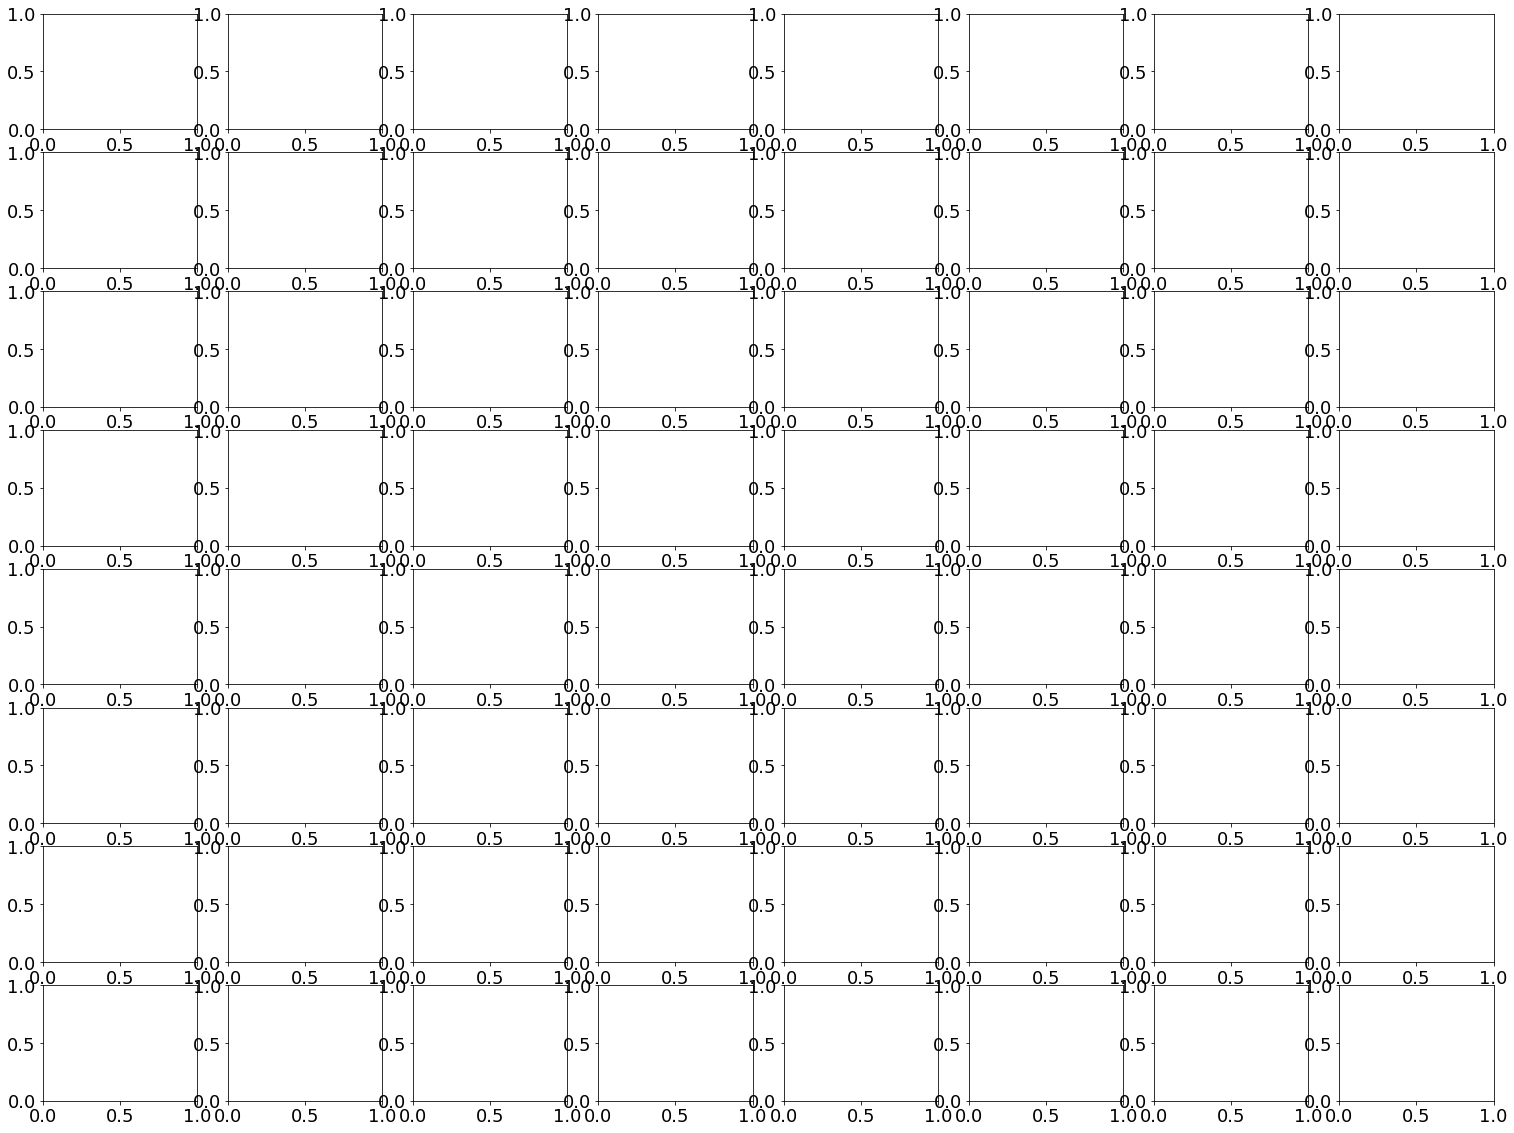

In [52]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_artifact.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['artifact']['test'].imgs[data_artifact.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address, pilmode="L"), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_artifact.loc[idx]['top_1'] == data_artifact.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_artifact.loc[idx]['top_1'] + ' | ' + data_artifact.loc[idx]['model'], color=color)
    likelihood = data_artifact.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'data_artifact' is not defined

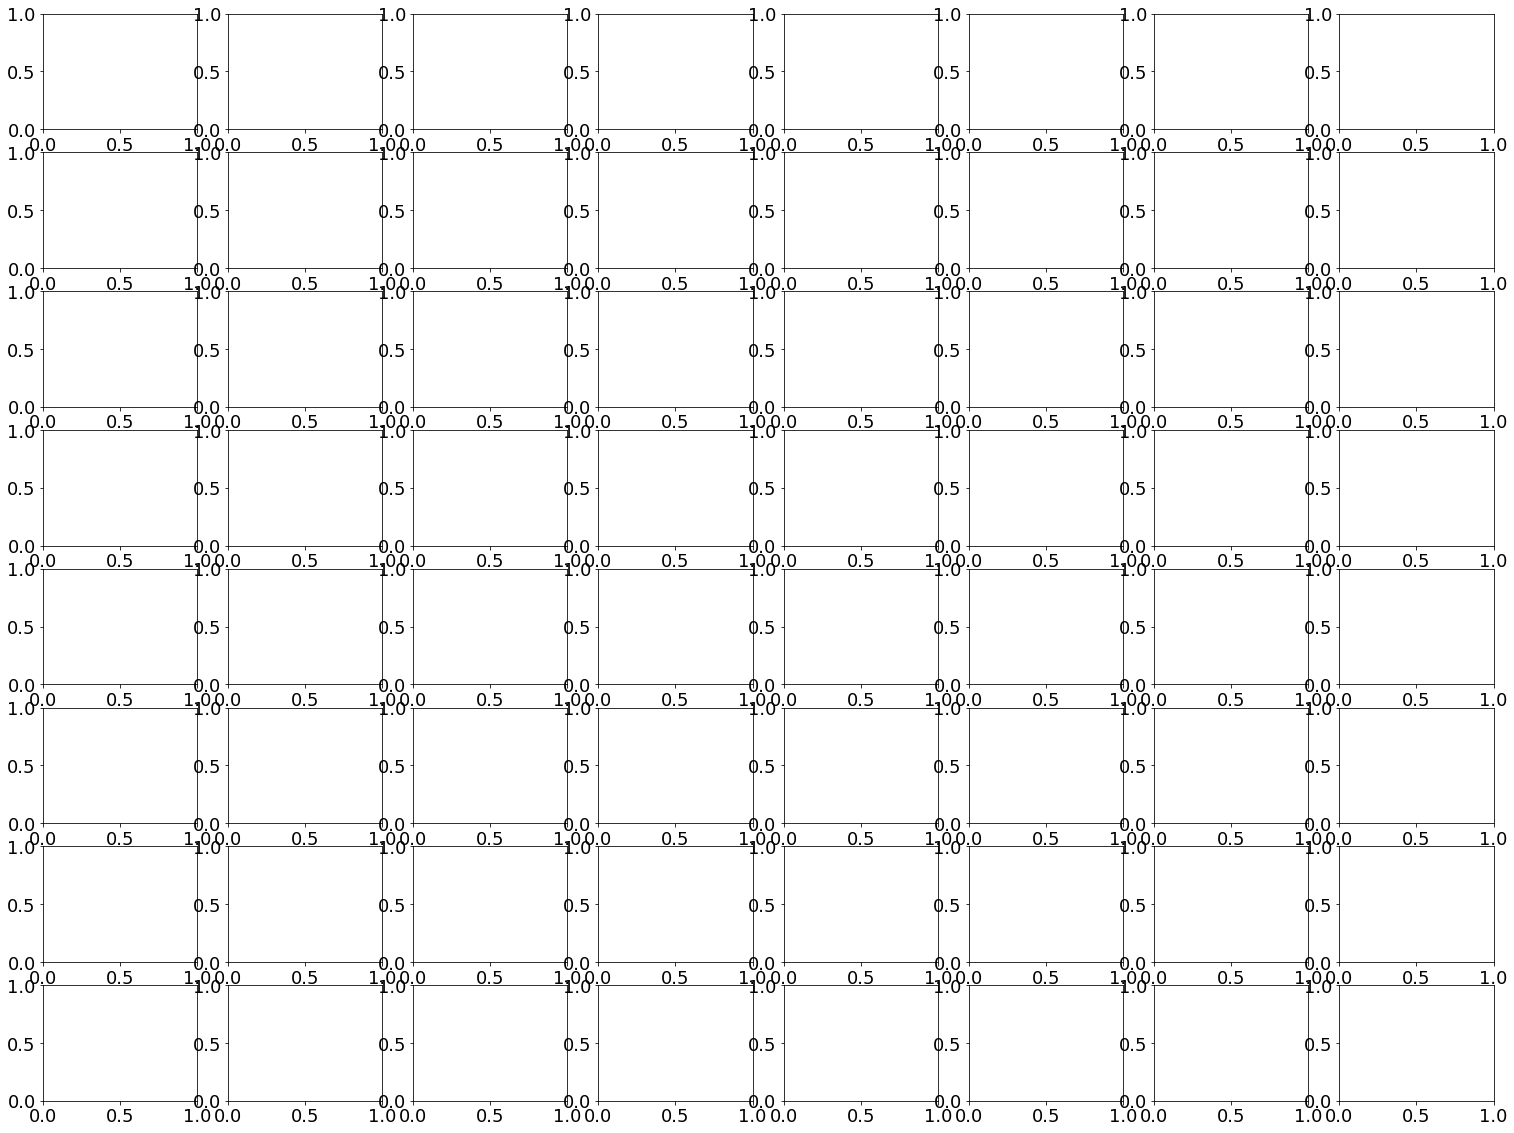

In [53]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_artifact.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['artifact']['test'].imgs[data_artifact.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address, pilmode="L"), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_artifact.loc[idx]['top_1'] == data_artifact.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_artifact.loc[idx]['top_1'] + ' | ' + data_artifact.loc[idx]['model'], color=color)
    likelihood = data_artifact.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

#### Accuracy

In [54]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
df_acc = pd.DataFrame({model_name: {task: f1_score(data_artifact[(data_artifact['model']==model_name) & (data_artifact['task']==task)]["top_1"], 
                                                               data_artifact[(data_artifact['model']==model_name) & (data_artifact['task']==task)]["goal"],
                                                  average = 'micro')
                                    for task in args.tasks} 
                       for model_name in model_artifact})

ax = df_acc.T.plot.bar(rot=20, figsize=(fig_width, fig_width//4), fontsize=20)
test_ = df_acc
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=60)
plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=18)
ax.set_title(f'Animal vs Artifact images f1 score for re-trained models', size=22)
ax.set_ylabel('Accuracy', size=20)
ax.set_xlabel('Model', size=20);

TypeError: no numeric data to plot

### Summary

#### Computation time

NameError: name 'df_gray' is not defined

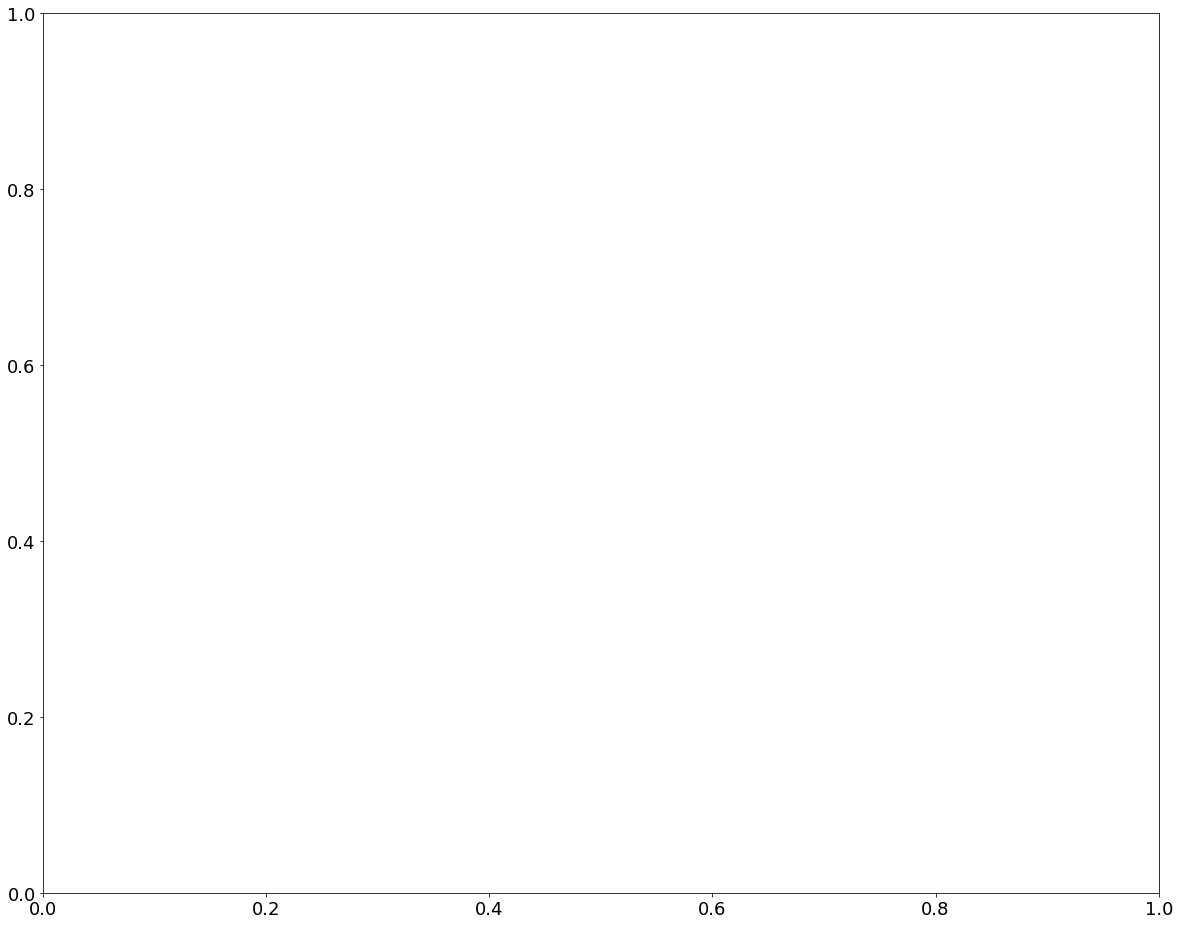

In [55]:
fig, axs = plt.subplots(len(models_vgg), 1, figsize=(fig_width, fig_width*phi/2))
for color, df_, label, legend in zip(['gray', 'red'], [df_gray, df], ['black', 'color'], ['Grayscale', 'Regular']):
    for ax, model_name in zip(axs, models_vgg):
        ax.set_ylabel('Frequency', fontsize=20) 
        df_[df_['model']==model_name]['time'].plot.hist(bins=150, lw=1, label=str(legend+ ' ' + model_name), ax=ax, color=color, density=True)
        ax.legend(loc='upper right', fontsize=20)
        ax.set_xlim(df_gray['time'].quantile(.01), df_gray['time'].quantile(.99))
        ax.legend(bbox_to_anchor=(1.18, .35), loc='lower right')
axs[-1].set_xlabel('Processing time (s)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20);

#### Accuracy

In [56]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
for task in args.tasks:
    df_acc = pd.DataFrame({model_name: {label: f1_score(df_[(df_['model']==model_name) & (df_['task']==task)]["top_1"], 
                                                                   df_[(df_['model']==model_name) & (df_['task']==task)]["goal"],
                                                       average='micro')
                                        for label, df_ in zip(['original', 'gray'], [df, df_gray])} 
                           for model_name in models_vgg})

    ax = df_acc.T.plot.bar(rot=30, figsize=(fig_width, fig_width//4), fontsize=18)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
    plt.legend(bbox_to_anchor=(1.16, .35), loc='lower right', fontsize=16)
    ax.grid(which='both', axis='y')
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
    ax.set_title(f'Experiment 3 - color vs gray images, task: {task}', size=20)
    ax.set_ylabel('F1 Score', size=18)
    plt.show();

NameError: name 'df' is not defined

#### Conclusion

We tested the networks on the ImageNet dataset with a grayscale filter applied on the input. The networks keeps a good mean accuracy on the grayscale dataset (about 94%). Note that the Vgg Gray networks achieves the task with a gray scale applied with a sightly better mean accuracy ([experiment 4](#exp4)) but not on the regular 'test' dataset ([experiment 1](#exp1)).

<a id="exp5"></a>
## Experiment 5: Image processing and recognition on rotated images :

In addition we tested all networks on our IMAGENET dataset while rotating the image around the center by -180° to +180°.

In [57]:
scriptname = 'UltraFastCat/experiment_rotate.py'

In [58]:
%%writefile {scriptname}

#import model's script and set the output file
from experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

angles = np.arange(-180, 181, 1)
angle = 0

datetag = '2022-02-11'
filename = f'results/{datetag}_results_rotate_{args.HOST}.json'
print(f'{filename=}')



def main():
    if os.path.isfile(filename):
        df_angle = pd.read_json(filename)
    else:
        i_trial = 0
        df_angle = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'angle', 'device_type'])   
        # image preprocessing
        for task in args.tasks:
            print(task)
            #for angle in angles :
            print(angle)
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data = transforms.functional.rotate(data, angle=float(angle), expand = True)
                data, label, = data.to(device), label.to(device)
                for model_name in models_vgg:
                    model = models_vgg[model_name].to(device)
                    with torch.no_grad():
                        goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                        model_task = 'animal' if 'animal' in model_name else 'artifact'
                        tic = time.time()
                        out = model(data).squeeze(0)
                        if model_name == 'vgg_16':
                            temp_, likelihood = 0, 0
                            model_task = 'Imagenet_challenge'
                            percentage = torch.nn.functional.softmax(out, dim=0) * 100
                            for idx in np.arange(0,1000,1):
                                if idx in match[task]:
                                    likelihood += math.exp(percentage[idx].item())
                                else:
                                    temp_ += math.exp(percentage[idx].item())  
                            likelihood = likelihood/temp_
                        else:
                            likelihood = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                        top_1 = 'target' if likelihood>50 else 'distractor'
                        elapsed_time = time.time() - tic 
                    df_angle.loc[i_trial] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                           'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type, 'angle':angle}
                    #print(f'The {model_name} model categorize {model_task} with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : {task}, {goal}')
                    i_trial += 1

        df_angle.to_json(filename)
main()

Overwriting UltraFastCat/experiment_rotate.py


In [59]:
%run -int {scriptname}

Re-training pretrained model... models/re-trained_vgg16_gen_animal.pt
Traning vgg16_gen_animal, image_size = 256, p (Grayscale) = 0


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 5.93 GiB total capacity; 962.08 MiB already allocated; 44.00 MiB free; 972.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


IPython CPU timings (estimated):
  User   :       1.63 s.
  System :       0.41 s.
Wall time:       1.74 s.


<Figure size 432x288 with 0 Axes>

In [60]:
model_animal = []
#datetag = '2022-01-24'
model_artifact = []
filename = f'results/{datetag}_results_rotate_{args.HOST}.json'
df_angle = pd.read_json(filename)
data_animal = df_angle.loc[df_angle['model_task'] == 'animal']
data_artifact = df_angle.loc[df_angle['model_task'] == 'artifact']
for model in models_vgg:
    model_animal.append(model) if 'animal' in model else model_artifact.append(model)

ValueError: Expected object or value

### Animal

#### Image display 

Here is the images with the highest likelihood of the networks :

NameError: name 'data_animal' is not defined

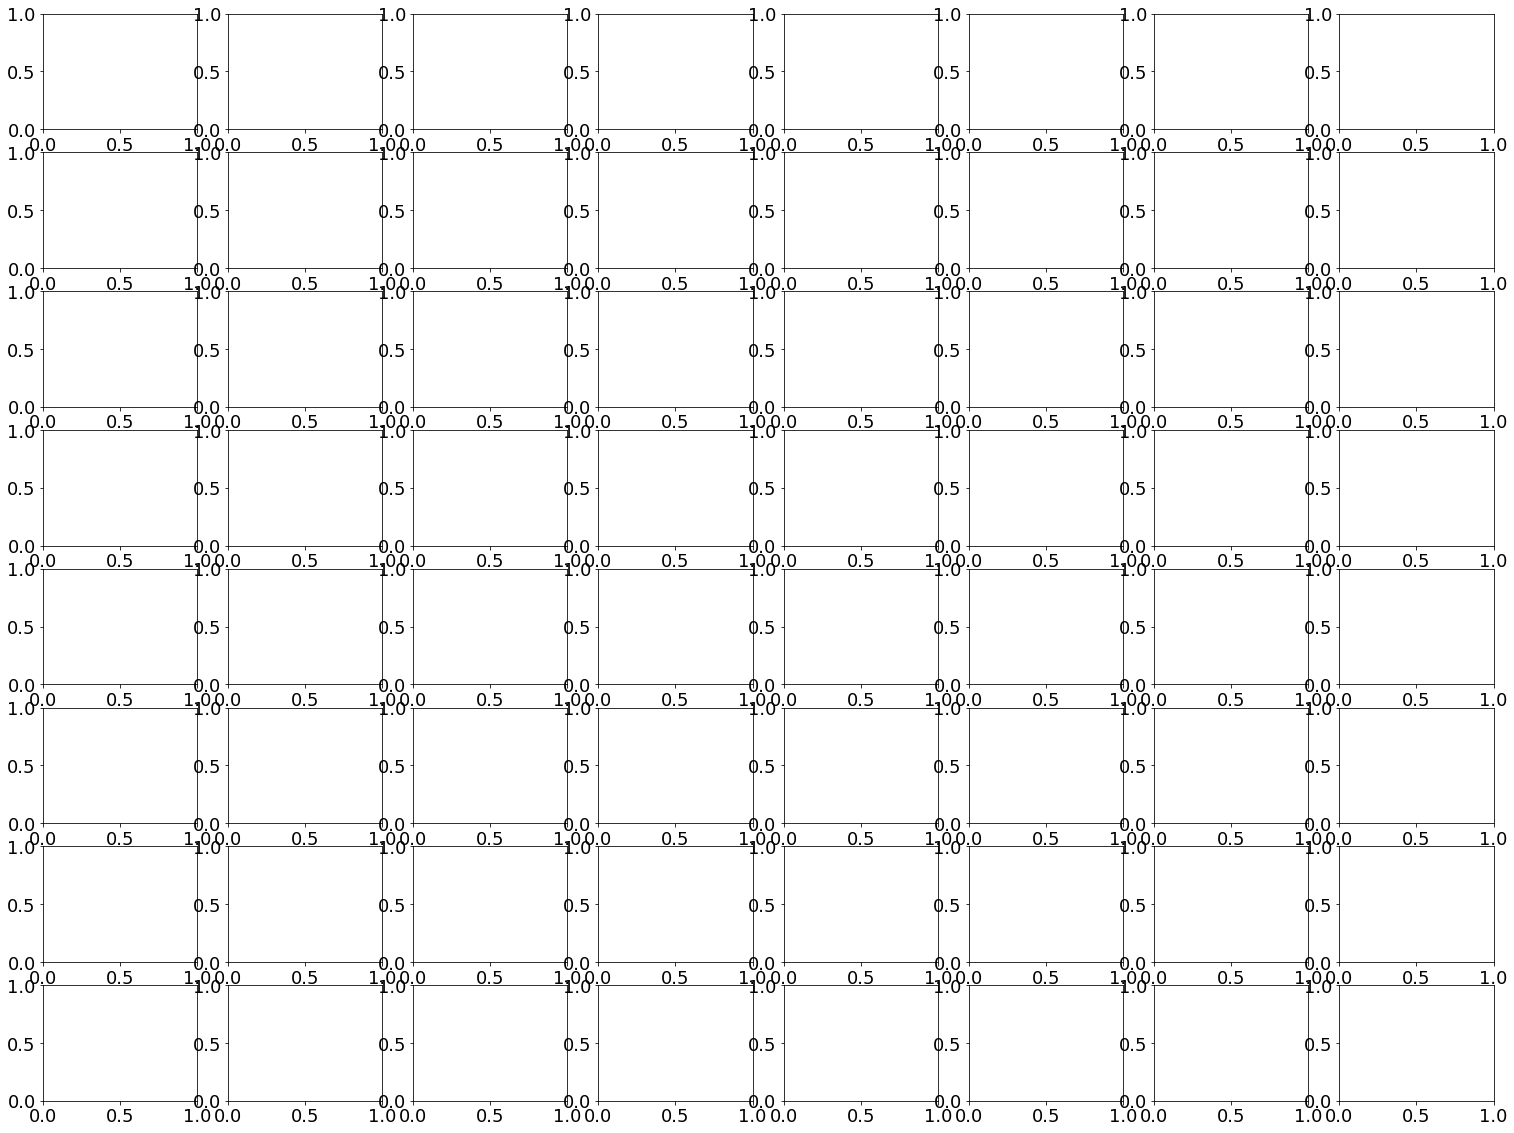

In [61]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_animal.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_animal.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_animal.loc[idx]['top_1'] == data_animal.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_animal.loc[idx]['top_1'] + ' | ' + data_animal.loc[idx]['model'] + ' | ' + str(data_animal.loc[idx]['angle']), color=color)
    likelihood = data_animal.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'data_animal' is not defined

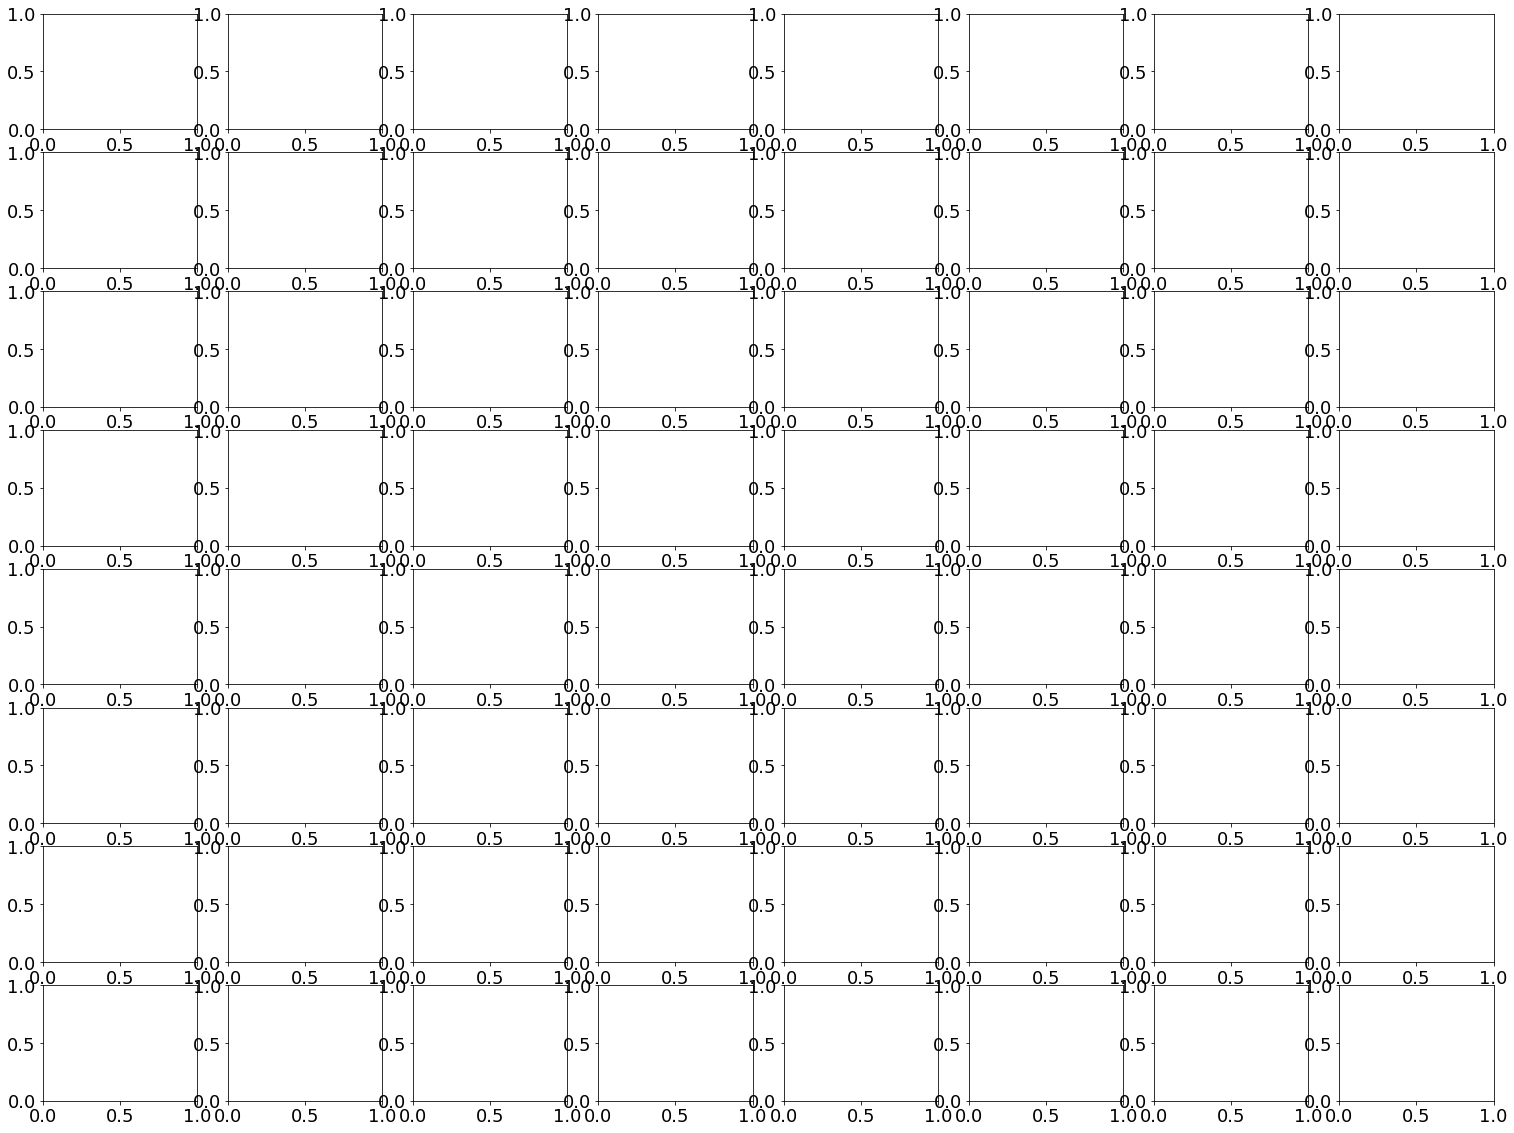

In [62]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_animal.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[data_animal.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_animal.loc[idx]['top_1'] == data_animal.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_animal.loc[idx]['top_1'] + ' | ' + data_animal.loc[idx]['model'] + ' | ' + str(data_animal.loc[idx]['angle']), color=color)
    likelihood = data_animal.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color) 
fig.set_facecolor(color='white')

#### Accuracy 

In [63]:
animal_acc = []
artifact_acc = []
animal = df_angle.loc[df_angle['task'] == 'animal']
artifact = df_angle.loc[df_angle['task'] == 'artifact']
for model_name in models_vgg:
    animal_acc.append(accuracy_score(animal[animal['model']==model_name]["top_1"], animal[animal['model']==model_name]["goal"]))
    artifact_acc.append(accuracy_score(artifact[artifact['model']==model_name]["top_1"], artifact[artifact['model']==model_name]["goal"]))

df_angle_test = pd.DataFrame({"accuracy animal": animal_acc, "accuracy artifact": artifact_acc}, index = models_vgg)
ax = df_angle_test.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=18, fmt='%.3f', rotation=60, label_type = 'edge')
plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=15)
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title(f'Experiment 1 - Accuracy Animal vs Artifact', size=20)
ax.set_xlabel('Model', size=20);
plt.show();

NameError: name 'df_angle' is not defined

### Artifact

#### Image display :

Here is the images with the highest likelihood of the networks :

NameError: name 'data_artifact' is not defined

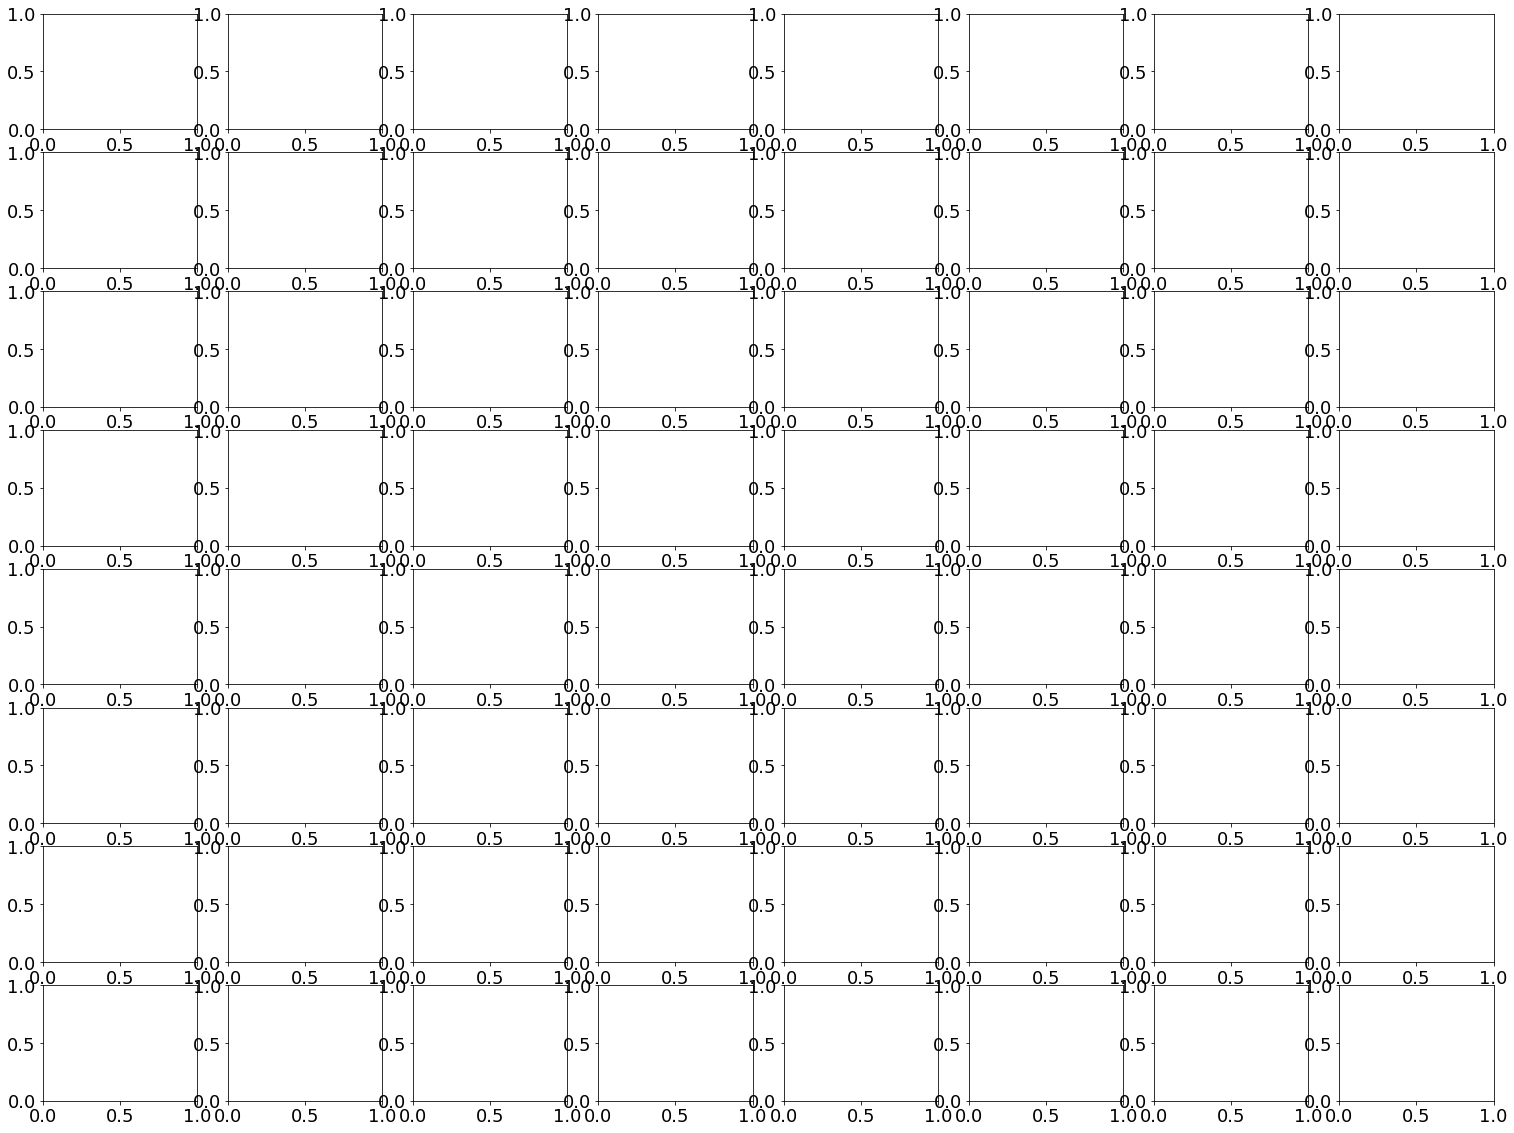

In [64]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_artifact.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['artifact']['test'].imgs[data_artifact.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_artifact.loc[idx]['top_1'] == data_artifact.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_artifact.loc[idx]['top_1'] + ' | ' + data_artifact.loc[idx]['model'] + ' | ' + str(data_artifact.loc[idx]['angle']), color=color)
    likelihood = data_artifact.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'data_artifact' is not defined

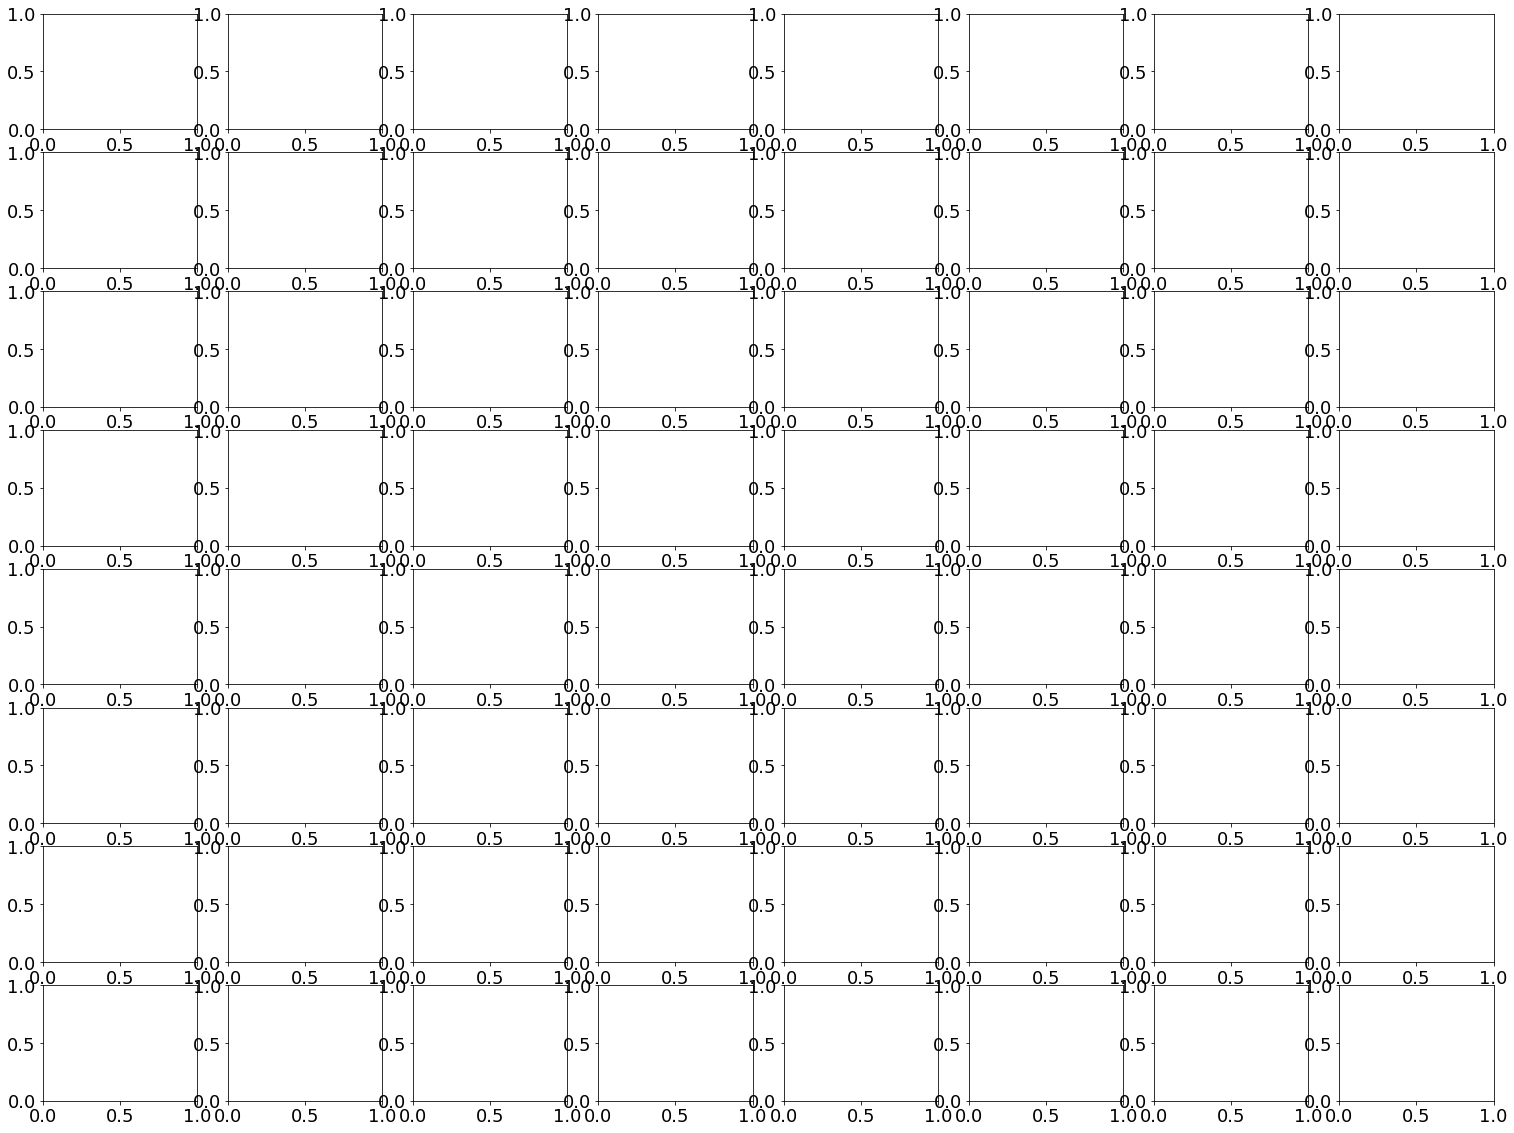

In [65]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(data_artifact.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['artifact']['test'].imgs[data_artifact.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if data_artifact.loc[idx]['top_1'] == data_artifact.loc[idx]['goal'] else 'r'
    ax.set_xlabel(data_artifact.loc[idx]['top_1'] + ' | ' + data_artifact.loc[idx]['model'] + ' | ' + str(data_artifact.loc[idx]['angle']), color=color)
    likelihood = data_artifact.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

#### Accuracy

In [66]:
animal_acc = []
artifact_acc = []
animal = df_angle.loc[df_angle['task'] == 'animal']
artifact = df_angle.loc[df_angle['task'] == 'artifact']
for model_name in models_vgg:
    animal_acc.append(accuracy_score(animal[animal['model']==model_name]["top_1"], animal[animal['model']==model_name]["goal"]))
    artifact_acc.append(accuracy_score(artifact[artifact['model']==model_name]["top_1"], artifact[artifact['model']==model_name]["goal"]))

df_angle_test = pd.DataFrame({"accuracy animal": animal_acc, "accuracy artifact": artifact_acc}, index = models_vgg)
ax = df_angle_test.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=18, fmt='%.3f', rotation=60, label_type = 'edge')
plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=15)
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title(f'Experiment 1 - Accuracy Animal vs Artifact', size=20)
ax.set_xlabel('Model', size=20);
plt.show();

NameError: name 'df_angle' is not defined

### Summary

#### Accuracy

In [67]:
model_animal = []
datetag = '2022-02-13'
model_artifact = []
filename = f'results/{datetag}_results_rotate_2_{args.HOST}.json'
df_sheat = pd.read_json(filename)
df_sheat

ValueError: Expected object or value

NameError: name 'df_angle' is not defined

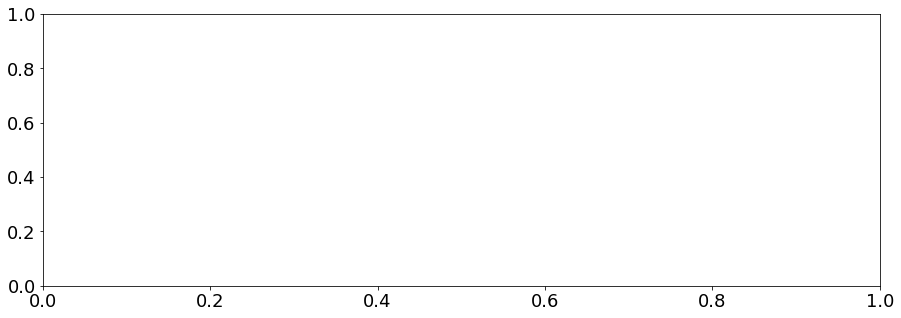

In [68]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/len(df_angle['model'].unique())) for i,k in enumerate(df_angle['model'].unique())})
df_mean = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
angles = np.arange(-180, 181, 1)
import statistics
for model_name in df_angle['model'].unique():
    df_mean = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
    for j,angle in enumerate(angles):
        if angle < -35:
            accuracy = f1_score(df_angle[(df_angle['model']==model_name)  & (df_angle['task']=='animal') & (df_angle['angle']==angle)]["top_1"], 
                                                               df_angle[(df_angle['model']==model_name) & (df_angle['task']=='animal') & (df_angle['angle']==angle)]["goal"],
                                                                average='micro')
            df_mean.loc[j] = {'model':model_name, 'mean_prediction':accuracy, 'var':angle} 
        else: 
            df_mean.loc[j] = {'model':model_name, 'mean_prediction':float(df_sheat[(df_sheat['model']==model_name) & (df_sheat['var']==angle)]["mean_prediction"]),
                                'var':angle}
    #dev = statistics.pstdev(df_mean["mean_prediction"])
    #mean = statistics.mean(df_mean["mean_prediction"])
    #print(model_name, 'dev: ', str(dev*100))
    #print(model_name, 'mean: ', str(mean*100))
    df_mean[(df_mean['model']==model_name)].plot.scatter(x="var", y="mean_prediction", c=[color_dict[model_name],],
                                                        alpha=.5, marker='o', s=40, lw=0, label=model_name, ax=ax)
    ax.legend(loc='center right', fontsize = 12)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0, 1)
    ax.set_xlim(-185, 185)
    #plt.set_cmap('Blues')
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_ylabel('Accuracy', size= 25, fontweight='bold')
    ax.set_xlabel('Rotation (°)', size= 25, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.2, .5), loc='center', fontsize=20)
    plt.xticks(fontsize=20,  fontweight='bold')
    plt.yticks(fontsize=20,  fontweight='bold');
    #plt.savefig('IJCNN_fig.5.pdf')
    plt.tight_layout();

#### Todo : table mean + std

#### Computation time

NameError: name 'df_angle' is not defined

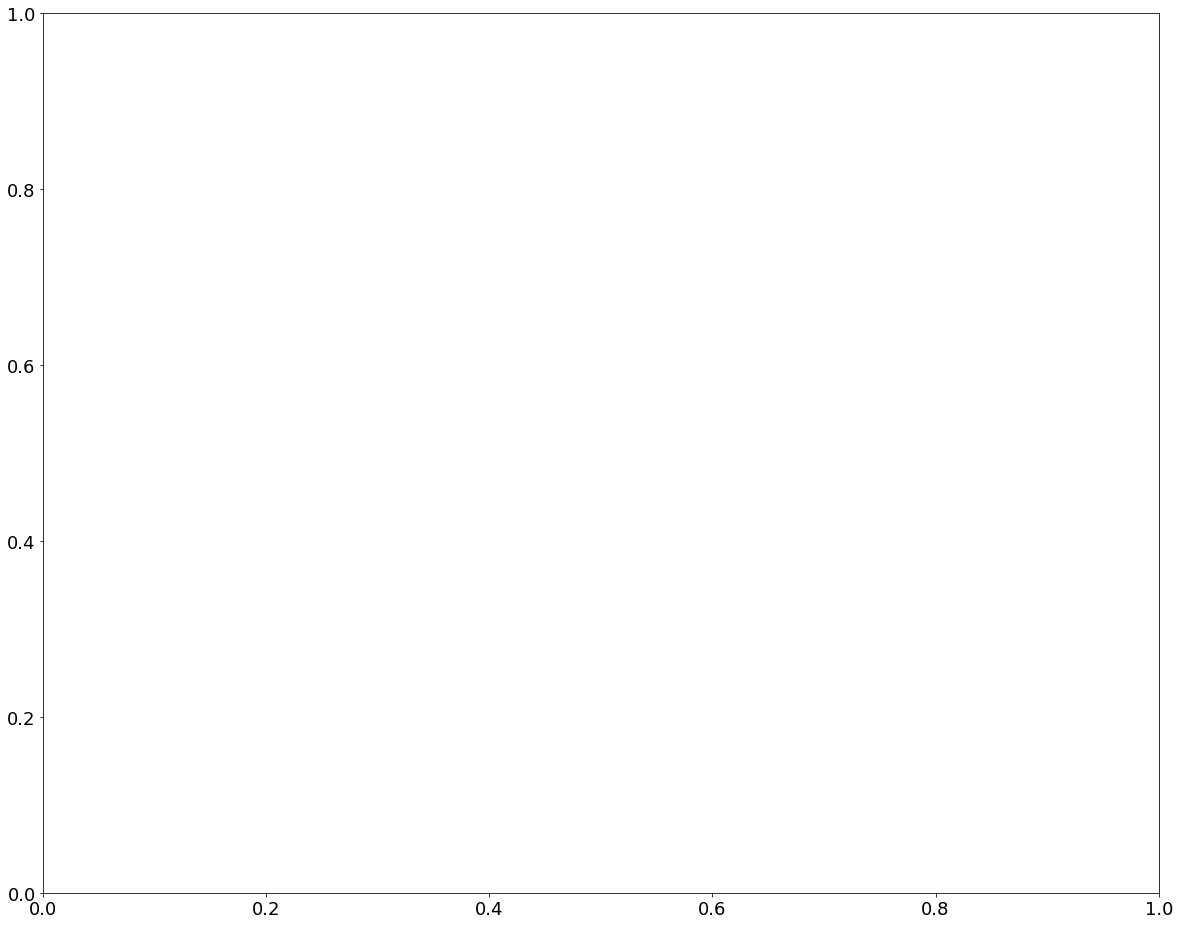

In [69]:
fig, axs = plt.subplots(len(models_vgg), 1, figsize=(fig_width, fig_width*phi/2), sharex=True, sharey=True)
cmap = plt.cm.get_cmap('inferno')
color_dict = pd.Series({k:cmap(i/len(df_angle['model'].unique())) for i,k in enumerate(df_angle['model'].unique())})
for ax, color, model_name in zip(axs, color_dict, models_vgg):
    df_angle[df_angle['model']==model_name]['time'].plot.hist(bins=50, lw=1, label=model_name,ax=ax, color=[color_dict[model_name],], density=True)
    ax.set_xlim(df_angle['time'].quantile(.01), df_angle['time'].quantile(.99))
  #  ax.set_ylim(0, 3500)
    ax.legend(bbox_to_anchor=(1.21, .35), loc='lower right', fontsize=15)
    ax.grid(which='both', axis='y')
    ax.set_xlabel('Processing time (s): ' + model_name, size=22)
    ax.set_ylabel('')
axs[0].set_title('Distribution of the Processing time (s). Processed on : ' + args.HOST + '_' + str(df_angle['device_type'][0]), size = 20)
axs[len(models_vgg)//2].set_ylabel('Frequency', fontsize=22);

#### Conclusion

The image size or a gray filter during training does not seem to impact the robustness to rotation as all three networks follow the same accuracy level for the categorization. Furthermore,
these three networks maintain a good accuracy during the process (VGG GEN 90.272 +/- 2.05, VGG GRAY 89.464 +/-2.72, VGG SCALE 89.222: +/- 2.722) (see Figure 5). As the networks seems robust to relection [experiment 2](#exp2), to the resolution [experiment 3](#exp3) (in a short range centered in the training resolution) and to grayscale [experiment 4](#exp4), the robustness of the categorization to different image transformations by the models are similar to that reported in psychophysics. 

# Experiment 6, a comparison between performances *in vivo* and *in sillico* : Test on Serre 2007 dataset

 As a control, we tested the networks on the dataset of [Serre & al](http://vision.stanford.edu/teaching/cs131_fall1415/lectures/Serre2007.pdf). This dataset contains a total of $600$ targets (images containing an animal) and $600$ distractors (images not containing an animal).

In [70]:
scriptname = 'UltraFastCat/experiment_serre.py'

In [71]:
%%writefile {scriptname}

#import model's script and set the output file
from experiment_train import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#datetag = '2022-02-08'
filename = f'results/{datetag}_results_serre_polar_{HOST}.json'
print(f'{filename=}')
serre = ['targets', 'distractors']
paths['animal']['test'] = '/home/INT/jeremie.j/Serre_2007'

# Output's set up
def main():
    if os.path.isfile(filename):
        df_serre = pd.read_json(filename)
    else:
        df_serre = pd.DataFrame([], columns=['model', 'model_task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
        i_trial = 0
        # image preprocessing
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        # Displays the input image of the model
        for i_image, (data, label) in enumerate(dataloaders['animal']['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg:
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'targets' in image_datasets['animal']['test'].imgs[i_image][0] else 'distractor'
                    model_task = 'animal' if 'animal' in model_name else 'artifact'
                    tic = time.time()
                    out = model(data).squeeze(0)
                    if model_name == 'vgg_16':
                        temp_, likelihood = 0, 0
                        model_task = 'Imagenet_challenge'
                        percentage = torch.nn.functional.softmax(out, dim=0) * 100
                        for idx in np.arange(0,1000,1):
                            if idx in match['animal']:
                                likelihood += math.exp(percentage[idx].item())
                            else:
                                temp_ += math.exp(percentage[idx].item())  
                        likelihood = likelihood/temp_
                    else:
                        likelihood = float((torch.sigmoid(out) * 100).detach().cpu().numpy()[0])
                    top_1 = 'target' if likelihood>50 and model_task == task else 'distractor'
                    elapsed_time = time.time() - tic
                df_serre.loc[i_trial] = {'model':model_name, 'model_task':model_task, 'likelihood':likelihood, 'time':elapsed_time, 
                                         'fps': 1/elapsed_time, 'goal': goal, 'i_image':i_image, 'top_1':top_1,
                                         'filename':image_datasets['animal']['test'].imgs[i_image][0], 'device':device.type}
                print(f'The {model_name} model categorize {model_task} with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtrue : animal, {goal}')
                i_trial += 1
    df_serre.to_json(filename)
main()

Overwriting UltraFastCat/experiment_serre.py


In [72]:
%run -int {scriptname}

Re-training pretrained model... models/re-trained_vgg16_gen_animal.pt
Traning vgg16_gen_animal, image_size = 256, p (Grayscale) = 0


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 5.93 GiB total capacity; 962.08 MiB already allocated; 44.00 MiB free; 972.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


IPython CPU timings (estimated):
  User   :       1.58 s.
  System :       0.37 s.
Wall time:       1.69 s.


<Figure size 432x288 with 0 Axes>

In [73]:
#datetag = '2022-02-08'
filename = f'results/{datetag}_results_serre_polar_{HOST}.json'
df_serre = pd.read_json(filename)
df_serre

ValueError: Expected object or value

## Image display

Here is the images with the highest likelihood of the networks :

NameError: name 'df_serre' is not defined

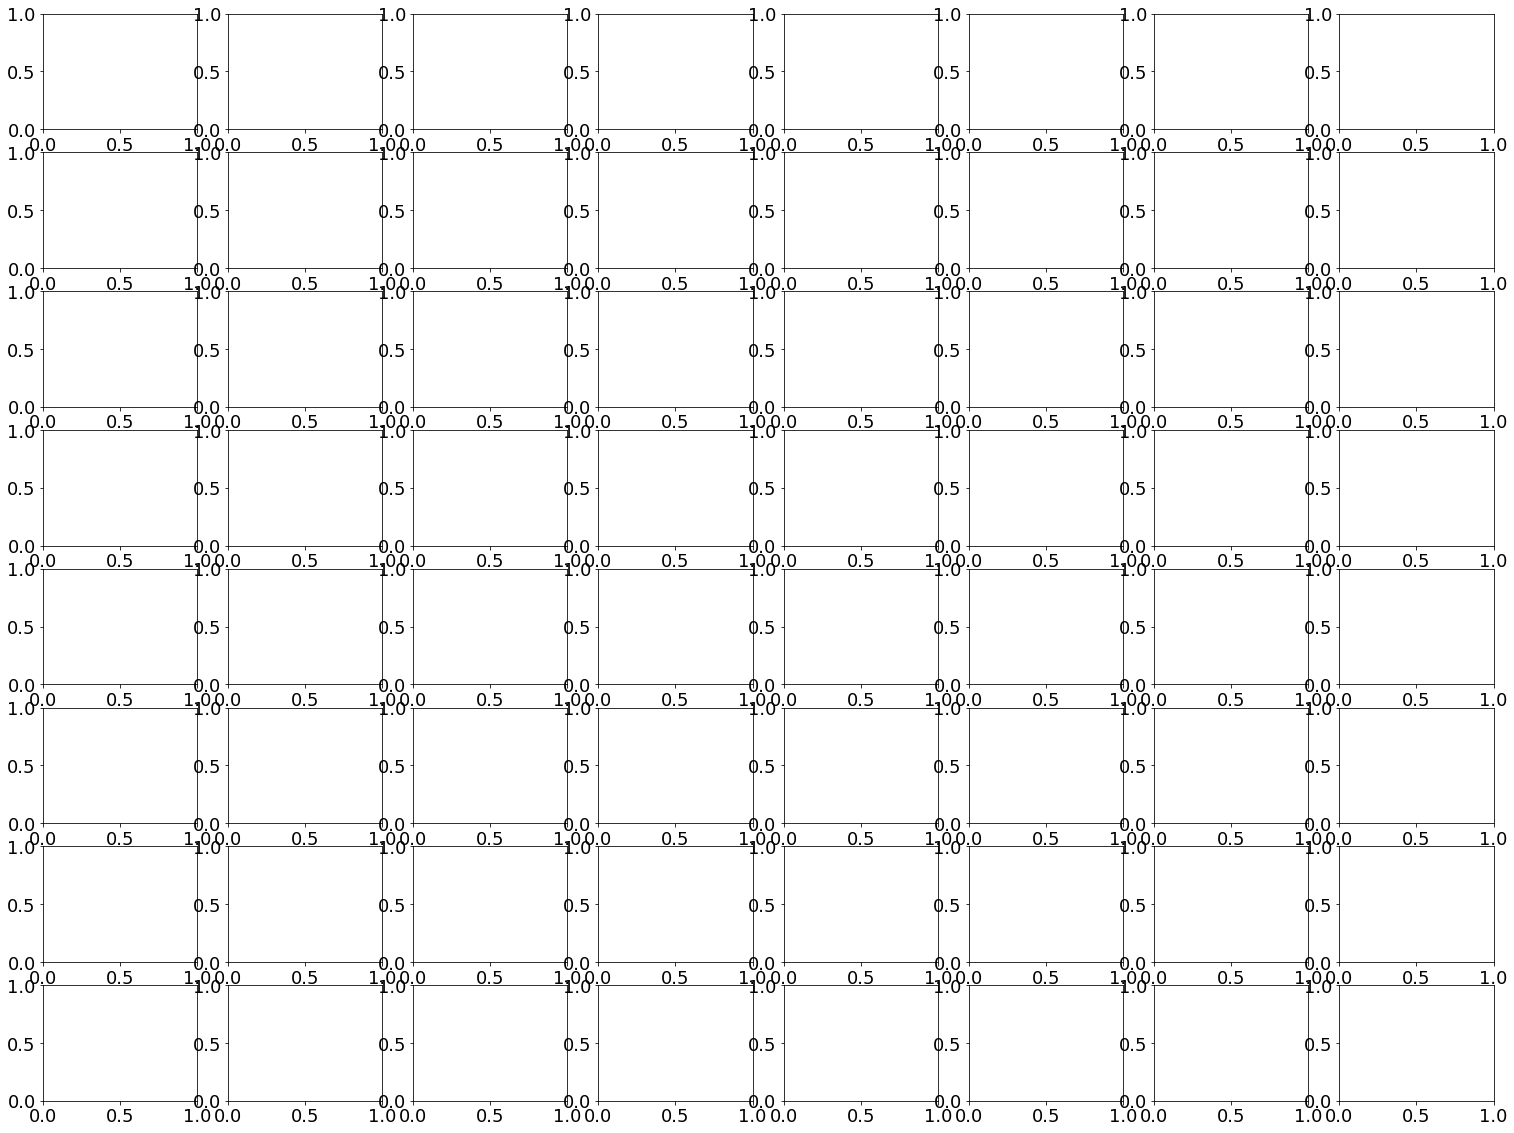

In [74]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_serre.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_serre.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_serre.loc[idx]['top_1'] == df_serre.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_serre.loc[idx]['top_1'] + ' | ' + df_serre.loc[idx]['model'], color=color)
    likelihood = df_serre.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

Here is the images with the lowest likelihood of the networks :

NameError: name 'df_serre' is not defined

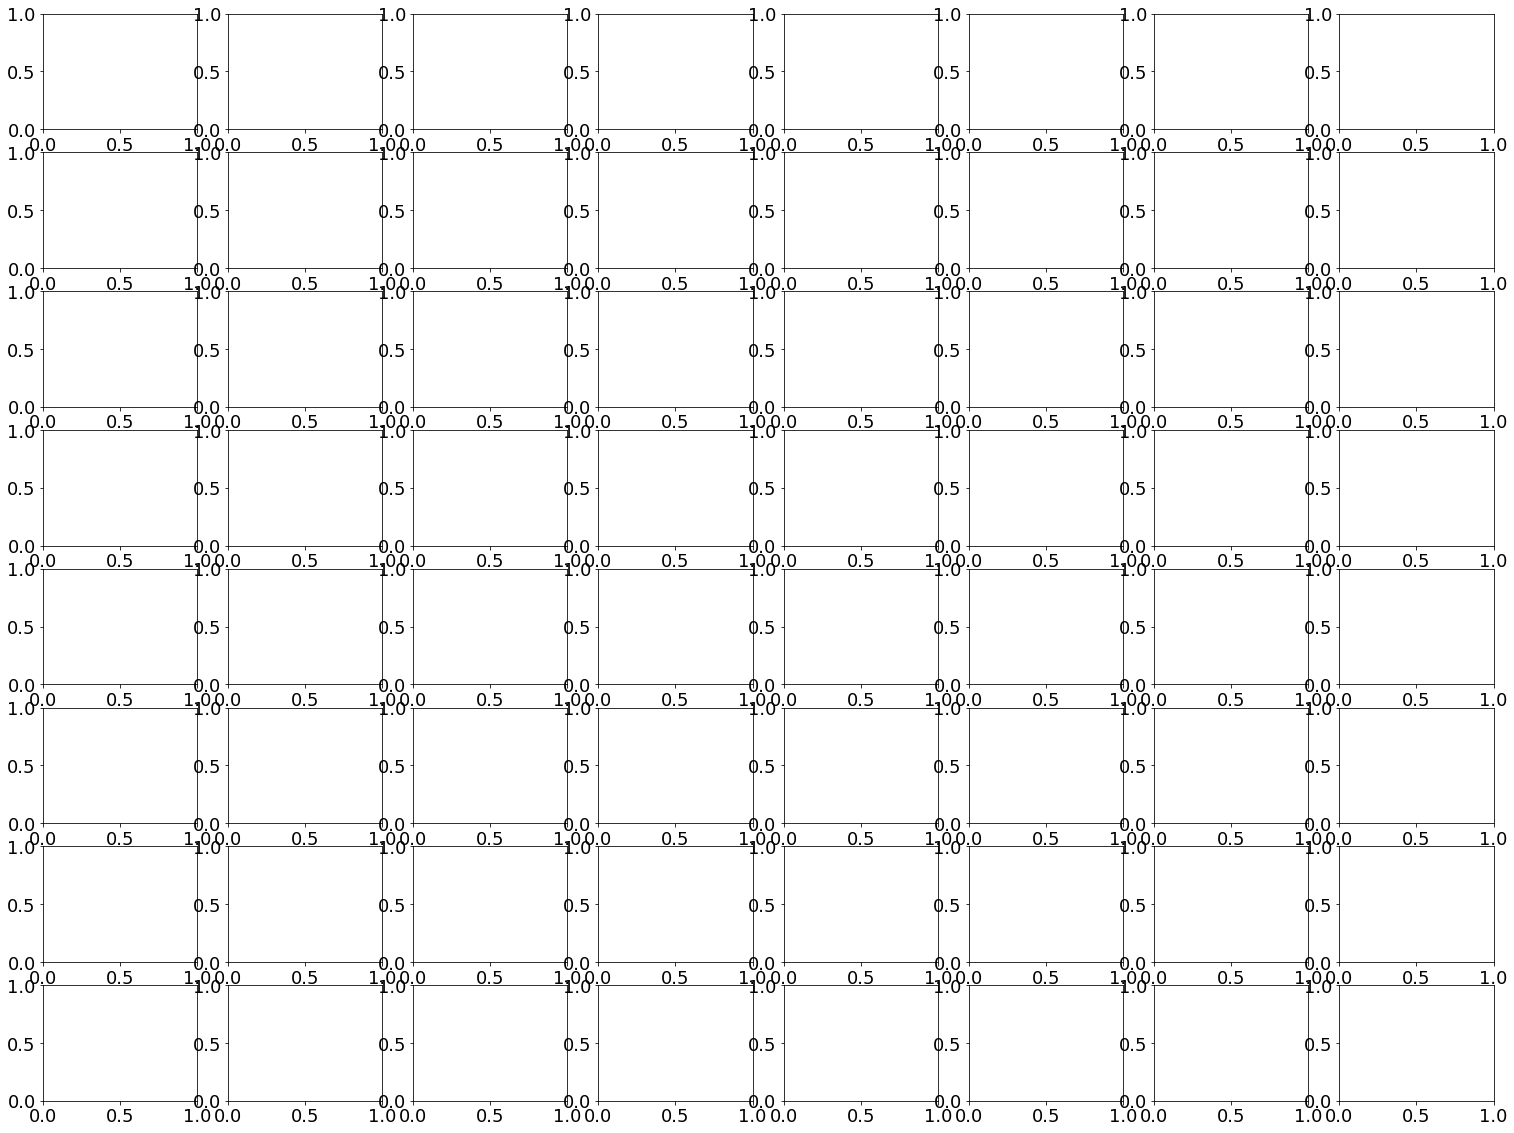

In [75]:
import imageio
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_serre.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_datasets['animal']['test'].imgs[df_serre.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_serre.loc[idx]['top_1'] == df_serre.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_serre.loc[idx]['top_1'] + ' | ' + df_serre.loc[idx]['model'], color=color)
    likelihood = df_serre.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

## Accuracy

In [76]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
df_acc = pd.DataFrame({'accuracy': [accuracy_score(df_serre[df_serre['model']==model_name]["top_1"], df_serre[df_serre['model']==model_name]["goal"]) for model_name in models_vgg]}, index=models_vgg)
ax = df_acc.plot.bar(rot=30, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
ax.bar_label(ax.containers[0], padding=-24, color='black', fontsize=14, fmt='%.3f')
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title('Average accuracy top_1 : for each models - experiment 1', size=20)
ax.set_xlabel('Model', size=20);

NameError: name 'df_serre' is not defined

## Heuristic

NameError: name 'df_serre' is not defined

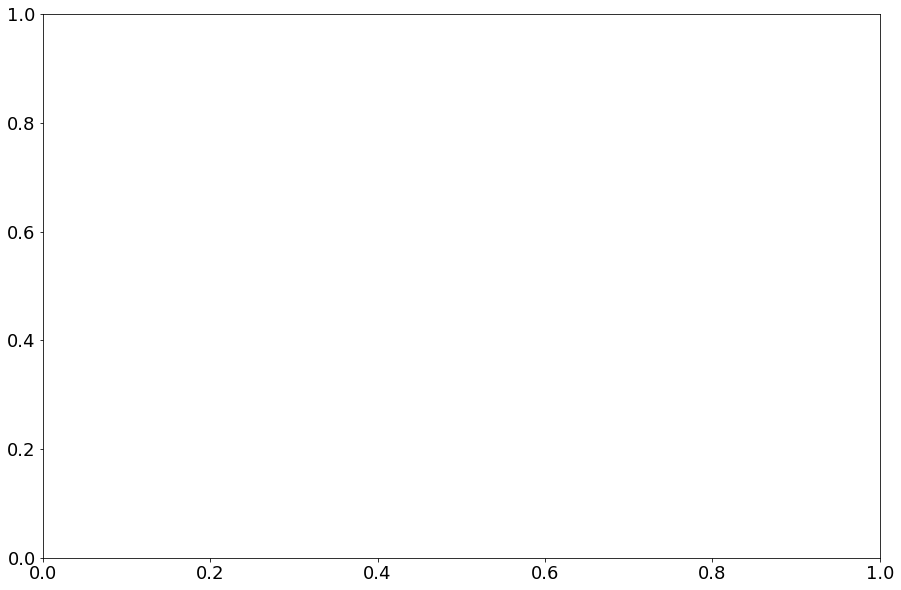

In [77]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
df_mean = pd.DataFrame([], columns=['heuristic', 'var', 'goal'])
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/len(df_serre['goal'].unique())) for i,k in enumerate(df_serre['goal'].unique())})
model_animal = []
model_artifact = []
data_animal = df_serre.loc[df_serre['model'] == 'vgg16_gen_animal']
data_artifact = df_serre.loc[df_serre['model'] == 'vgg16_gen_artifact']
for i_image in df_serre['i_image'].unique():
    heuristic = 1 - (1 - float(data_animal[(data_animal['i_image']==i_image)]["likelihood"]/100)) * float(data_artifact[(data_artifact['i_image']==i_image)]["likelihood"]/100)
    df_mean.loc[i_image] = {'heuristic':heuristic, 'var':i_image, 'goal':list(data_animal.goal)[i_image]}      
for goal in df_serre['goal'].unique():
    df_mean[(df_mean['goal']==goal)].plot.scatter(x="var", y="heuristic",  c=[color_dict[goal],],
                                                         alpha=0.5, marker='o', lw=0, ax=ax, label=goal)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Heuristic', size= 20)
ax.set_xlabel('i image', size= 20)
plt.legend(bbox_to_anchor=(1.1, .5), loc='center', fontsize=14,)
ax.set_title('Heuristic : likelihood = 1 - (1 - likelihood_animal)  * likelihood_artifact', size = 20);
plt.tight_layout();

## Kernel Density Estimation

In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable. This function uses Gaussian kernels and includes automatic bandwidth determination.

NameError: name 'df_serre' is not defined

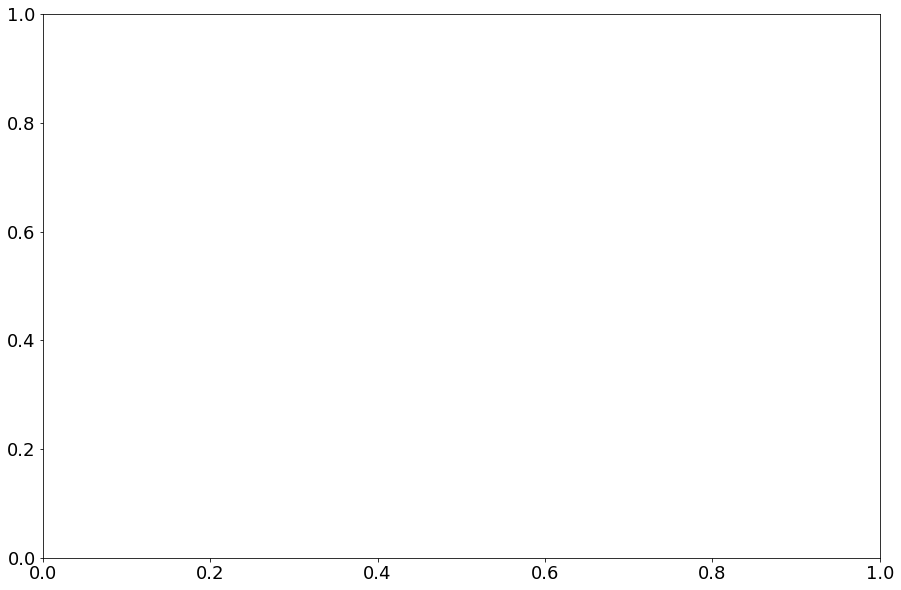

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
data_animal = df_serre.loc[df_serre['model_task'] == 'animal']
data_artifact = df_serre.loc[df_serre['model_task'] == 'artifact']
df_test = pd.DataFrame({"accuracy animal": list(data_animal.likelihood), "accuracy artifact": list(data_artifact.likelihood), "goal": list(data_animal.goal)})
sns.kdeplot(data=df_test, x="accuracy animal", y="accuracy artifact", hue="goal", fill=True, ax=ax)
ax.set_ylabel('Likelihood artifact', size= 20)
ax.set_xlabel('Likelihood animal', size= 20)
ax.set_ylim(0, 100)
ax.set_xlim(0, 100)
ax.set_title('Kernel Density Estimation (KDE)', size = 20);
plt.tight_layout();

## Comparison with physiologic data from Serre & al 2007

In [79]:
df_serre_07 = pd.read_csv('https://raw.githubusercontent.com/laurentperrinet/PerrinetBednar15/master/database/AnimalnessIndex.csv', header=None)#, index_col=['A', 'B', 'C'])

likes_ = []
goals = []
top1_human = []
top1_model = []
data_vgg_gen = df_serre.loc[df_serre['model'] == 'vgg16_gen_animal']
for i in range(len(df_serre_07)):
    top_1_human = 'target' if df_serre_07.iloc[i, 1]>50 else 'distractor'
    top_1_model = 'target' if df_serre_07.iloc[i, 2]>50 else 'distractor'
    top1_human.append(top_1_human)
    top1_model.append(top_1_model)
    for j in range(len(data_vgg_gen)):
        if df_serre_07.iloc[i, 0] in data_vgg_gen.iloc[j, 7] :
            goals.append(data_vgg_gen.iloc[j, 2])
            if data_vgg_gen.iloc[j, 2] == 'target':
                likes_.append(round(data_vgg_gen.iloc[j, 3]))
            else:
                likes_.append(100-round(data_vgg_gen.iloc[j, 3]))
                df_serre_07.iloc[i, 1] = 100 - df_serre_07.iloc[i, 1]
                df_serre_07.iloc[i, 2] = 100 - df_serre_07.iloc[i, 2]

df_serre_07.insert( 3, 'human', top1_human)
df_serre_07.insert( 4, 'model', top1_model)
df_serre_07.insert(5, 'Gen', likes_)
df_serre_07.insert(6, 'goals', goals)
df_serre_07

NameError: name 'df_serre' is not defined

KeyError: 'Gen'

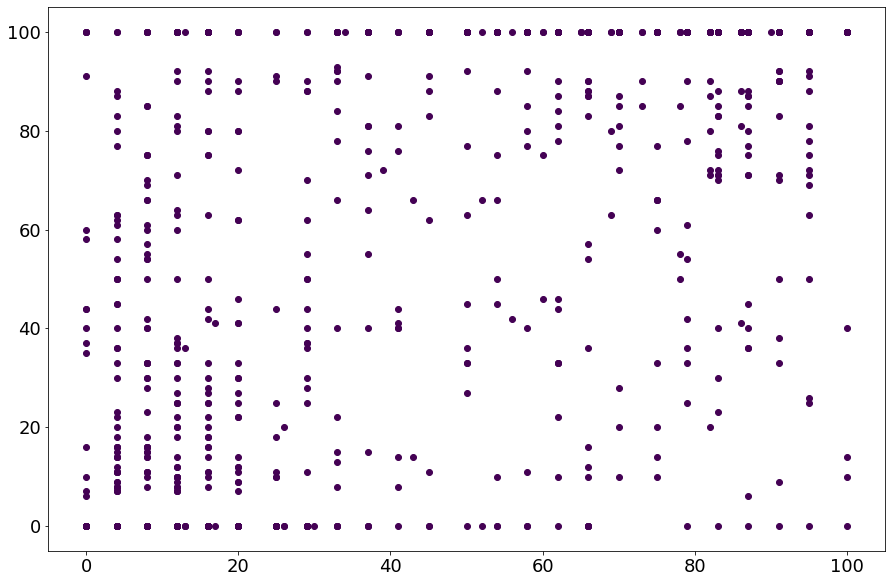

In [80]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/3) for i,k in enumerate(range(3))})
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
names_ = ['Model Serre_07', 'Human', 'Vgg_Gen_Animal']
plt.scatter(df_serre_07[1], df_serre_07[2], label='Model Serre_07', color=color_dict[0])
plt.scatter(df_serre_07[1], df_serre_07['Gen'], label='Vgg_Gen_Animal', color=color_dict[2])
#plt.scatter(df_serre_07[1], df_serre_07[4], label='Vgg_Gen_Animal', color=color_dict[4])
ax.tick_params(axis='y', labelsize=14)
plt.xticks(fontsize=20,  fontweight='bold')
plt.yticks(fontsize=20,  fontweight='bold')
plt.legend(bbox_to_anchor=(1.17, .5), loc='center', fontsize=20)
ax.set_ylabel("""Model's likelihood""", size= 24, fontweight='bold' )
ax.set_xlabel("""Human's Accuracy""", size= 24, fontweight='bold' )
plt.tight_layout()
#plt.savefig('IJCNN_fig.5.pdf');

In [81]:
for i in df_serre_07[1]:
    moy_image = 0
    for mode_ in [2, 'Gen']
    if float(df_serre_07.iloc[i, 1]) > .5 and float(df_serre_07.iloc[i, mode_]) >.5:
        moy_image += (df_serre_07.iloc[i, 1]*df_serre_07.iloc[i, 1] + (1-df_serre_07.iloc[i, 1])*df_serre_07.iloc[i, 1])
    print('Average number of correct categorizations common to humans and the mode_' + mode_ +': '+ moy_image/1200)

SyntaxError: invalid syntax (3111032472.py, line 3)

https://github.com/laurentperrinet/PerrinetBednar15/blob/master/notebooks/5%20notebook_figure_animalness.ipynb

## Conclusion

The networks obtain an accuracy on the 'animal' synset similar to those found in the model and neurophysiological data of [Serre & al (2007)](http://vision.stanford.edu/teaching/cs131_fall1415/lectures/Serre2007.pdf) (about 83\%). Yet, the bias found in is also present in the dataset used by [Serre & al (2007)](http://vision.stanford.edu/teaching/cs131_fall1415/lectures/Serre2007.pdf).  when we compare the performances of humans on this dataset with the performances achieved by the network on an image-by-image basis we found in  [experiment 1](#exp1). However, we also found a high correspondence (about 84%) between the correct predictions of human and our model. Indeed for some images the networks failed the categorization but the human succeeds and vice versa. For some images both the network and human succeed or failed to categorize an animal. These exemples could be the reflection of the specific features on which humans or our models rely to perform their categorization.

# Bonus : How did we use the the pre-trained VGG network trained on the [Imagenet](http://image-net.org/) dataset ?

Todo mettre le softmax après

In [82]:
scriptname =  'UltraFastCat/bonus_vgg16.py'

In [83]:
%%writefile {scriptname}

#import model's script and set the output file

from UltraFastCat.experiment_train import *
#from src.model import *
from PIL import ImageFile
import math
ImageFile.LOAD_TRUNCATED_IMAGES = True
filename = f'results/{datetag}_results_vgg16_pytorch_{HOST}.json'
print(f'{filename=}')

def softmax(vec):
    exponential = np.exp(vec)
    probabilities = exponential / np.sum(exponential)
    return probabilities

task = 'animal'
match = []
class_loader = 'imagenet_label_to_wordnet_synset.json'
with open(class_loader, 'r') as fp: 
    imagenet = json.load(fp)
labels = []
for a, img_id in enumerate(imagenet):
    labels.append(imagenet[img_id]['label'])
    syn_ = wn.synset_from_pos_and_offset('n', int(imagenet[img_id]['id'].replace('-n','')))
    sem_ = syn_.hypernym_paths()[0]
    for i in np.arange(len(sem_)):
        if task in sem_[i].lemmas()[0].name() :
            match.append(a)
            
models_vgg['vgg16'] = torchvision.models.vgg16(pretrained=True)
likelihood = {}
top_1 = {}
serre = ['targets', 'distractors']
paths['animal']['test'] = '/home/INT/jeremie.j/Serre_2007'
model_name = 'vgg16'
#def main():
if os.path.isfile(filename):
    test_serre = pd.read_json(filename)
else:
    i_trial = 0
    test_serre = pd.DataFrame([], columns=['model', 'goal', 'fps', 'time', 'i_image', 'filename', 
                                           'like_1', 'like_2', 'top_1_1', 'top_1_2', 'device_type']) 
        # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
    pprint('GO!')
    for i_image, (data, label) in enumerate(dataloaders[task]['test']):
        for i in ['1', '2']:
            likelihood[i], top_1[i] = 0,0
        data, label = data.to(device), label.to(device)
        model = models_vgg['vgg16'].to(device)
        temp_ = 0
        with torch.no_grad():
            goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
            tic = time.time()
            out = model(data).squeeze(0)
            percentage = torch.nn.functional.softmax(out, dim=0) * 100
            for idx in np.arange(0,1000,1):
                if idx in match:
                    likelihood['1'] += percentage[idx].item()
                    likelihood['2'] += np.exp(percentage[idx].item())  
            likelihood['2'] = softmax(likelihood['2'])
            top_1['1'] = 'target' if likelihood['1']>50 else 'distractor'
            top_1['2'] = 'target' if likelihood['2']>50 else 'distractor' 
            elapsed_time = time.time() - tic
        test_serre.loc[i_trial] = {'model':model_name, 'like_1':likelihood['1'],'like_2':likelihood['2'],
                                   'top_1_1':top_1['1'], 'top_1_2':top_1['2'], 'goal':goal, 'time':elapsed_time, 
                                   'fps': 1/elapsed_time, 'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0],
                                   'device_type':device.type}
        i_trial += 1
test_serre.to_json(filename)
#main()  

Overwriting UltraFastCat/bonus_vgg16.py


In [84]:
%run {scriptname}

Re-training pretrained model... models/re-trained_vgg16_gen_animal.pt
Traning vgg16_gen_animal, image_size = 256, p (Grayscale) = 0


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 5.93 GiB total capacity; 962.08 MiB already allocated; 44.00 MiB free; 972.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<Figure size 432x288 with 0 Axes>

In [85]:
filename = f'results/{datetag}_results_vgg16_pytorch_{HOST}.json'
results_bonus_vgg16 = pd.read_json(filename)
results_bonus_vgg16

ValueError: Expected object or value

## Accuracy

In [86]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
fig_width = 15
results = []
names = ['top_1_1', 'top_1_2']
for name in names:
    results.append(f1_score(results_bonus_vgg16[name],
                            results_bonus_vgg16["goal"],average='micro'))
df_acc = pd.DataFrame({'': results},index = names)
ax = df_acc.plot.bar(rot=30, figsize=(fig_width, fig_width//2), fontsize = 18)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
plt.legend(bbox_to_anchor=(1.15, .5), loc='right')
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
ax.set_ylabel('Accuracy', size= 20)
ax.set_xlabel('Methods', size= 20)
ax.set_title(f'Animal images f1 score for re-trained models with different depth', size=22)
#plt.savefig('Cosyne_fig2.1.pdf')

NameError: name 'results_bonus_vgg16' is not defined

## Todo : CCl